In [1]:
import glm_utils.preprocessing, glm_utils.bases
import sklearn.linear_model
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore, binned_statistic
import pickle
import pandas as pd
import seaborn as sns
from DN_tools import load_into_pandas, bases_dict, load_recording, get_xy, chunked_test_train_split, plot_glm_filter
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

import os
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

plt.style.use("W:/apalaci/code/janache/DNpaper.mplstyle")

# Helping functions

In [2]:

def convert_pvalue_to_asterisks(pv_list, explicit=False):
    from collections import OrderedDict
    pv_asterisks = OrderedDict(sorted({0.05:'*',0.01:'**',0.001:'***'}.items()))

    pv_strings = []
    for pv in pv_list:
        if np.isnan(pv) or (pv > 0.05):
            if not explicit:
                pv_strings.append('ns')
            else:
                pv_strings.append(f'{pv:.3f}')
        else:
            for key, pvstr in pv_asterisks.items():
                if pv < key:
                    pv_strings.append(pvstr)
                    break
    return pv_strings

def add_pv_bars_SNS_explicit(p_array,data_rpi,hierarchy_levels=[],pairs_tested=None,hierarchy_shift=0.075,pv_marker_width=0.01,pv_line_min=1.0,ymax=None,explicit_ns=True,explicit_pvs=False,ax=None,data_xpos=None,numbers_fontsize=7,asterisk_fontsize=10,max_one=True,line_lw=1):
    data_xpos = np.arange(len(data_rpi)) if data_xpos is None else data_xpos
    ax = plt.gca() if ax is None else ax
    pairs_tested = [[2*ii,2*ii+1] for ii in range(int(len(data_rpi)/2))] if pairs_tested is None else pairs_tested
    hierarchy_levels = np.arange(len(pairs_tested)) if len(hierarchy_levels)==0 else hierarchy_levels

    if max_one:
        p_array = np.clip(p_array,0,1)

    if explicit_pvs:
        pv_strings = [f"{pp:.1e}".replace("e-0", "e-") if pp < 0.005 else f"{pp:.2f}" for pp in p_array]
        # color_list = ['k']*len(pv_strings)
        color_list = ['k' if pp < 0.05 else 'grey' for pp in p_array]
        fontsize_list = [numbers_fontsize]*len(pv_strings)
    else:
        pv_strings = convert_pvalue_to_asterisks(p_array, explicit=explicit_ns)
        color_list = ['k' if '*' in pvstr else 'grey' for pvstr in pv_strings]
        fontsize_list = [asterisk_fontsize if '*' in pvstr else numbers_fontsize for pvstr in pv_strings]

    for bp, pv, cc, hlevel, text_fontsize in zip(pairs_tested, pv_strings, color_list, hierarchy_levels, fontsize_list):
        if not ((not explicit_ns) and '*' not in pv):
            baseline = hlevel*hierarchy_shift+pv_line_min

            ax.plot([data_xpos[bp[0]],data_xpos[bp[0]],data_xpos[bp[1]],data_xpos[bp[1]]], [baseline, baseline+pv_marker_width, baseline+pv_marker_width, baseline], lw=line_lw, color=cc, zorder=1)
            ax.text(np.mean(data_xpos[list(bp)]), baseline+pv_marker_width, pv, color=cc, size=text_fontsize, horizontalalignment='center', verticalalignment='bottom', bbox={'facecolor':'white', 'linewidth':0, 'alpha':1}, zorder=-1)
    if len(pv_strings) > 0:
        yticks = ax.get_yticks()
        if ymax != None:
            ax.set_ylim([0,ymax])
        ax.set_yticks(yticks)

def add_pv_extra_explicit(p_array,data_rpi,hierarchy_levels=[],pairs_tested=None,hierarchy_shift=0.075,pv_marker_width=0.01,pv_line_min=1.0,ax=None,data_xpos=None,numbers_fontsize=7,line_lw=1,padding=0.1,explicit_pvs=False,explicit_ns=True,asterisk_fontsize=10,ignore_ns=True):
    data_xpos = np.arange(len(data_rpi)) if data_xpos is None else data_xpos
    ax = plt.gca() if ax is None else ax
    pairs_tested = [[2*ii,2*ii+1] for ii in range(int(len(data_rpi)/2))] if pairs_tested is None else pairs_tested
    hierarchy_levels = np.arange(len(pairs_tested)) if len(hierarchy_levels)==0 else hierarchy_levels
    
    if explicit_pvs:
        p_array = np.clip(p_array,0,1)
        pv_strings = [f"p={pp:.1e}".replace("e-0", "e-") if pp < 0.005 else f"p={pp:.2f}" for pp in p_array]
        if not explicit_ns:
            pv_strings = [pvs if pp < 0.05 else 'ns' for pp, pvs in zip(p_array,pv_strings)]
        color_list = ['k' if pp < 0.05 else 'grey' for pp in p_array]
        fontsize_list = [numbers_fontsize]*len(pv_strings)
        # text_pad = 1.75*pv_marker_width
    else:
        pv_strings = convert_pvalue_to_asterisks(p_array, explicit=explicit_ns)
        color_list = ['k' if '*' in pvstr else 'grey' for pvstr in pv_strings]
        if not explicit_ns:
            pv_strings = [pvs if pp < 0.05 else 'ns' for pp, pvs in zip(p_array,pv_strings)]
        fontsize_list = [asterisk_fontsize if '*' in pvstr else numbers_fontsize for pvstr in pv_strings]
        # text_pad = -5*pv_marker_width

    if ignore_ns:
        should_be_plot = [pp < 0.05 for pp in p_array]
    else:
        should_be_plot = [True]*len(p_array)

    for bp, pv, cc, hlevel, text_fontsize, plot_condition in zip(pairs_tested, pv_strings, color_list, hierarchy_levels, fontsize_list, should_be_plot):
        if plot_condition:
            baseline = hlevel*hierarchy_shift+pv_line_min

            if '*' in pv:
                text_pad = -5*pv_marker_width
            else:
                text_pad = pv_marker_width
            ax.plot([data_xpos[bp[0]]+padding,data_xpos[bp[0]]+padding,data_xpos[bp[1]]-padding,data_xpos[bp[1]]-padding], [baseline, baseline+pv_marker_width, baseline+pv_marker_width, baseline], lw=line_lw, color=cc, zorder=1)
            ax.text(np.mean(data_xpos[list(bp)]), baseline+text_pad, pv, color=cc, size=text_fontsize, horizontalalignment='center', verticalalignment='bottom', bbox={'facecolor':'none', 'linewidth':0, 'alpha':1}, zorder=-1)
    
def compare_pair(data_pair,verbose=False):
    if np.any([shapiro(data_group).pvalue < 0.05 for data_group in data_pair]):
        if verbose: print('using mannwhitneyu')
        p = mannwhitneyu(*data_pair,alternative='two-sided').pvalue
    else:
        if verbose: print('using ttest_ind')
        p = ttest_ind(*data_pair, equal_var=False).pvalue
    return p

def _plot_bars(ax, df_plot, xlabel, ylims, color_palette, stripcolor_palette=['#666666'], marker_color='k', alpha_stripplot=1):
    sns.boxplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=color_palette, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 10, "markeredgecolor": marker_color, "markerfacecolor": marker_color, "linewidth": 5}, medianprops={"visible": False}, width=0.5)
    sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=False,legend=False,size=2,edgecolor='none',linewidth=0.5)

    ax.set_xticks(ax.get_xticks(), [label_dict[varname] for varname in variables_list], rotation=0, ha='center',va='center',fontsize=8)
    ax.tick_params(axis='x', which='major', length=0) # hides ticks without hiding ticklabel
    ax.set_ylim(ylims)
    ax.set_yticks(ylims)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Performance',fontsize=8)
    trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.yaxis.set_label_coords(-0.25, (ylims[1]-ylims[0])/2,transform=trans)

def _plot_bars_DM(ax, df_plot, xlabel, ylims, boxcolor_palette, alpha_stripplot, stripcolor_palette=['#666666']):

    hue_order=['left','right']

    sns.boxplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=boxcolor_palette, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 8, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5}, medianprops={"visible": False}, width=0.75)

    # Overwrite each box color manually
    for i, patch in enumerate(ax.patches[:8]):
        patch.set_facecolor(boxcolor_palette[i])

    # color mean lines of boxplots according to hue
    mean_lines = [child for child in ax.get_children() if isinstance(child, Line2D) and child.get_marker() == '_']
    for i, line in enumerate(mean_lines):
        if (i == 4 or i == 5) or (i == 0 or i == 1):
            line.set_markerfacecolor('k')
            line.set_markeredgecolor('k')
        elif (i == 2 or i == 3) or (i == 6 or i == 7):
            line.set_markerfacecolor('w')
            line.set_markeredgecolor('w')

    sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=True,legend=False, size=2, edgecolor='none', linewidth=0.5)
    # strip_collections = [c for c in ax.collections if isinstance(c, PathCollection)]
    # expected_n = len(hue_order) * len(variables_list)
    # assert len(strip_collections) >= expected_n, "Unexpected number of PathCollections!"
    # for i, coll in enumerate(strip_collections[-expected_n:]):
    #     if i >= 4:
    #         edgecolor = 'w'
    #     else:
    #         edgecolor = 'k'
    #     coll.set_edgecolor(edgecolor)

    ax.set_xticks(ax.get_xticks(), [label_dict[varname] for varname in variables_list], rotation=0, ha='center',va='center',fontsize=8)
    ax.tick_params(axis='x', which='major', length=0) # hides ticks without hiding ticklabel
    ax.set_ylim(ylims)
    ax.set_yticks(ylims)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Performance',fontsize=8)
    trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.yaxis.set_label_coords(-0.25, (ylims[1]-ylims[0])/2,transform=trans)

# General parameters and variables

In [3]:
color_perside_dict = {'MDN':'#164CA0','MDN undefined':'#164CA0','imposter left':'#D83288','imposter right':'k', 'DopaMeander left':'#D83288','DopaMeander right':'k','DNp17':'goldenrod','Roadrunner':'SeaGreen'}
color_perDN_dict = {'MDN':'#164CA0','imposter':'#D83288','DopaMeander':'#D83288','DNp17':'goldenrod','Roadrunner':'SeaGreen'}

labels_dict = {'v_fwd':r'$v_{fwd}$','v_ang':r'$v_{ang}$','abs_v_fwd':r'$|v_{fwd}|$','abs_v_ang':r'$|v_{ang}|$','pos_v_fwd':r'$v_{fwd}^+$','pos_v_ang':r'$v_{ang}^+$','neg_v_fwd':r'$v_{fwd}^-$','neg_v_ang':r'$v_{ang}^-$'}

raw_data_dir_path = 'W:/apalaci/code/janache'
results_dir_path = 'W:/apalaci/code/janache/res'
sample_frequency = 20000
isplit = 0 # nsplits = 5
redo_analysis = True
bin_width = 100; decimating_values = [10,10]
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
cutoff = 20
block_size = 5_000; n_block_min=5; test_size = 0.35; random_state = 42; starting_nbins = 32
window = bases_dict['window']

df = load_into_pandas(dir_path=raw_data_dir_path)
df = df[(df.to_ignore == False)&(df.DN != "Roadrunner")].reset_index(drop=True)

first_time = True
cm = 1/2.54
figsize_unit = 3*cm  # 5*cm

# Illustration elements

In [4]:
varname_bins_dict = {'v_ang':np.linspace(-250,250,200), 'v_fwd':np.linspace(-5,5,100), 'abs_v_fwd':np.linspace(-2,5,100), 'abs_v_ang':np.linspace(-10,250,100)}
iv = 0

subsampled_frequency = int(sample_frequency/bin_width)
window = int(3*subsampled_frequency)
T = np.arange(-window, 0)/subsampled_frequency

# plot_options = {'rowindex': 53,'varname': 'abs_v_fwd','ylims': [0,5],'yticklabels': [0,5],'xlims': [175,185],'ylabel': r'$|v_{fwd}|$ (mm/s)','filt_ylim': [0,0.5],'NL_lims': [0,1]}
plot_options = {'rowindex': 53,'varname': 'abs_v_fwd','ylims': [0,6],'yticklabels': [0,6],'xlims': [176,181],'ylabel': r'$|v_{fwd}|$ (mm/s)','filt_ylim': [0,0.5],'NL_lims': [0,1]}

rowindex = plot_options['rowindex']
varname = plot_options['varname']
ylims = plot_options['ylims']
yticklabels = plot_options['yticklabels']
xlims = plot_options['xlims']
ylabel = plot_options['ylabel']
filt_ylim = plot_options['filt_ylim']
NL_lims = plot_options['NL_lims']

xticklabels = [0,int(xlims[-1]-xlims[0])]
y_names = [varname]

if first_time:
    B = glm_utils.bases.raised_cosine(neye = bases_dict['neye'], ncos = bases_dict['ncos'], kpeaks = bases_dict['kpeaks'], b = bases_dict['b'], nbasis = bases_dict['nbasis'])
    B = B[-window:]
    basis_projection = glm_utils.preprocessing.BasisProjection(B)

    filename, csv_path, DN_type = df.iloc[rowindex][['filename','abs_file_path','DN']]
    print(DN_type)
    singleDN_df = load_recording(csv_path=csv_path)
    x, ys = get_xy(singleDN_df,y_names)

    time = np.arange(0,len(singleDN_df['v_fwd']))/sample_frequency
    time_raw = np.arange(len(singleDN_df['spike']))/sample_frequency
    time_model = time_raw[::bin_width] - (bin_width/(2*sample_frequency))
    raw_time = time_model[window:]

    y_means = np.mean(ys, axis=0)
    y_stds = np.std(ys, axis=0)
    y_zscored = zscore(ys, axis=0)

    X, y_m = glm_utils.preprocessing.time_delay_embedding(x, ys, window_size=window, flatten_inside_window=True, exclude_t0=True)
    X_b = basis_projection.transform(X)
    raw_y = y_m[:,iv]

    X_train, X_test, y_train, y_test = chunked_test_train_split(X_b,y_m,block_size=block_size,n_block_min=n_block_min,test_size=test_size,random_state=random_state)

    # Fit
    lr = sklearn.linear_model.LassoCV(max_iter=20000)
    lr.fit(X_train, y_train[:,iv])

    # Predictions
    y_pred = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    # Attempt to estimate nonlinearity (last record: ~12% constant value)
    nbins = starting_nbins
    not_finished = True
    while (nbins != 5) and not_finished:
        bin_edges_quantilebased = np.quantile(y_pred, np.linspace(0, 1, nbins + 1))
        try:
            statistic, bin_edges, binnumber = binned_statistic(y_pred, y_train[:,iv], statistic='mean', bins=bin_edges_quantilebased, range=None)
            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
            constant_input = False
            not_finished = False
        except ValueError as e:
            if str(e) != 'The smallest edge difference is numerically 0.':
                print("ValueError: ",e)
            else:
                nbins -= 1

    if (nbins == 5) and not_finished:
        statistic = [np.nanmean(y_train[:,iv])]
        bin_centers = [np.nanmean(y_pred)]
        constant_input = True

    if np.sum(np.isnan(statistic)) > 0:
        y_pred_test_nl = np.interp(y_pred_test, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
    else:
        y_pred_test_nl = np.interp(y_pred_test, bin_centers, statistic)

    # Filter
    basis_weights = lr.coef_
    estimated_filters = basis_projection.inverse_transform(basis_weights)
    estimated_filters = estimated_filters.reshape((-1,window))

    y_pred_full = lr.predict(X_b)
    y_pred_full_nl = y_pred_full + np.interp(y_pred_full, bin_centers, statistic)

    varname_bins = varname_bins_dict[varname]
    if len(bin_centers)>1:
        nonlinearity_estimate = np.interp(varname_bins, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
        nonlinearity_estimate[ varname_bins > bin_centers[~np.isnan(statistic)].max() ] = np.nan
        nonlinearity_estimate[ varname_bins < bin_centers[~np.isnan(statistic)].min() ] = np.nan
    else:
        nonlinearity_estimate = np.interp(varname_bins, bin_centers, statistic)
    nonlinearity_estimate = nonlinearity_estimate + varname_bins
    
    first_time = False

imposter


C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\4066374785.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'fig/merged_illustrations.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


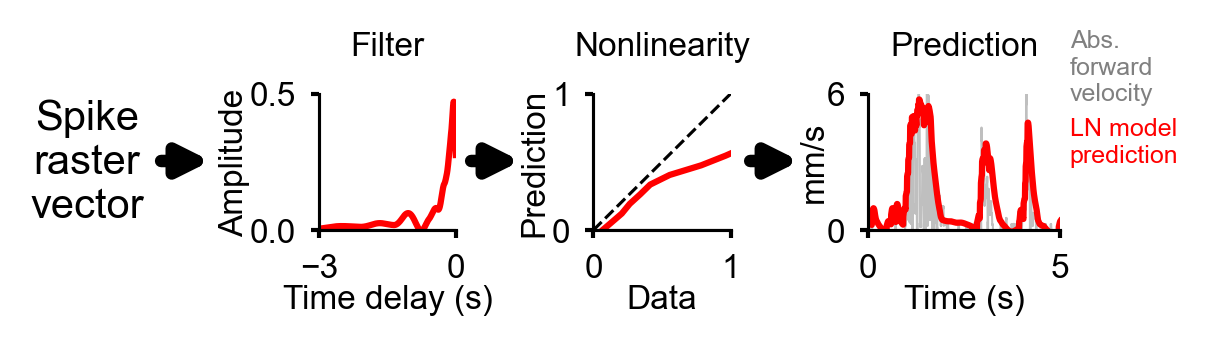

In [5]:
height_ratios = [1]
wspace = 1
width_ratios = [0.5+wspace/4, 1+wspace/4, 1+wspace/4, 1.5+wspace/4]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace)
lw = 1.5

fig,axes = plt.subplots(1,4,figsize=[(sum(width_ratios)+2*wspace)*figsize_unit/2,figsize_unit/2],dpi=300,layout='tight',gridspec_kw=gs_kw)

ax=axes[0]
ax.axis("off")
ax.text(-0.15,0.5,'Spike\nraster\nvector',va='center',ha='center',fontsize=10)

ax=axes[1]
ax.plot(T, estimated_filters[0,:], color='r',lw=lw)
ax.axhline(y=0,color='k',lw=0.5)
ax.set_ylim(filt_ylim)
ax.set_yticks(filt_ylim)
ax.set_xticks([0,-3])
ax.set_ylabel('Amplitude')
ax.yaxis.set_label_coords(-0.5, 0.5)
ax.set_xlabel('Time delay (s)',labelpad=0)
ax.set_title('Filter',y=1.1,fontsize=8)

ax=axes[2]
ax.plot(nonlinearity_estimate,varname_bins, lw=lw, color='r')
ax.axvline(0, c='k',lw=0.5)
ax.axhline(0, c='k',lw=0.5)
ax.plot(NL_lims, NL_lims, linestyle='--',lw=0.75,color='k')
ax.set_xlim(NL_lims)
ax.set_ylim(NL_lims)
ax.set_xticks(NL_lims)
ax.set_yticks(NL_lims)
ax.set_title('Nonlinearity',y=1.1,fontsize=8)
ax.set_xlabel('Data',labelpad=0)
ax.set_ylabel('Prediction',labelpad=0)
ax.yaxis.set_label_coords(-0.31, 0.5)

ax=axes[3]
ax.plot(raw_time, raw_y, lw=0.5, alpha=0.25, color='k', label='data')
ax.plot(time_model[window:], y_pred_full_nl, lw=lw, color='r', label='LN prediction')
ax.text(1.05,0.95,"Abs.\nforward\nvelocity", color='gray', fontsize=6, transform=ax.transAxes)
ax.text(1.05,0.5,"LN model\nprediction", color='r', fontsize=6, transform=ax.transAxes)
ax.set_xlim(xlims)
ax.set_xticks(xlims,xticklabels)
ax.set_ylim(ylims)
ax.set_yticks(ylims,yticklabels)
ax.set_xlabel('Time (s)',labelpad=0)
ax.set_ylabel('mm/s')
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.set_title('Prediction',y=1.1,fontsize=8)

# for x in [0.04, 0.32, 0.58]:
for x in [0.175, 0.425, 0.65]:
    arrow = mpl.patches.ConnectionPatch(
        (x,0.5),
        (x+0.04,0.5),
        coordsA=fig.transFigure,
        coordsB=fig.transFigure,
        color="black",
        arrowstyle="-|>",  # "normal" arrow
        mutation_scale=15,  # controls arrow head size
        linewidth=3,
        transform=fig.transFigure
    )
    fig.patches.append(arrow)

plt.savefig(f'fig/merged_illustrations.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# Filters

In [6]:
def _plot_filters(ax,lw=2,zero_line_lw=0.25,color_list=None):
    # for DN_side in filtered_df[(filtered_df.DN == DN_type)].side.unique():
        # if color_list is None:
        #     if (DN_type == 'DopaMeander') and DN_side == 'left':
        #         color_list = [color_perside_dict['DopaMeander left']]
        #     elif (DN_type == 'DopaMeander') and DN_side == 'right':
        #         color_list = [color_perside_dict['DopaMeander right']]
        #     else:
        #         color_list = [color_perDN_dict[DN_type]]

    for iv, varname in enumerate(variables_list):
        filename_list = filtered_df[(filtered_df.DN == DN_type)].filename.tolist()
        plot_glm_filter(ax=ax,estimated_filters_dict=estimated_filters_dict,filename_list=filename_list,varname=varname,T=T,main_color=color_list[iv],with_l2=False,with_individual_traces=False,linestyle=variables_linestyle[iv],lw=lw,zero_line_lw=zero_line_lw)
            
    ylims = ylims_dict[DN_type]
    ax.set_ylim(ylims)
    ax.set_yticks([ylims[0],0,ylims[1]])
    ax.set_yticklabels([ylims[0],0,ylims[1]])

    ax.set_ylabel('Amplitude')
    ax.yaxis.set_label_coords(-0.3, 0.5)

    ax.set_xlim([-3,0]) # 0.025])
    ax.set_xticks([0,-3])
    ax.set_xlabel('Time (s)',labelpad=0)

c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


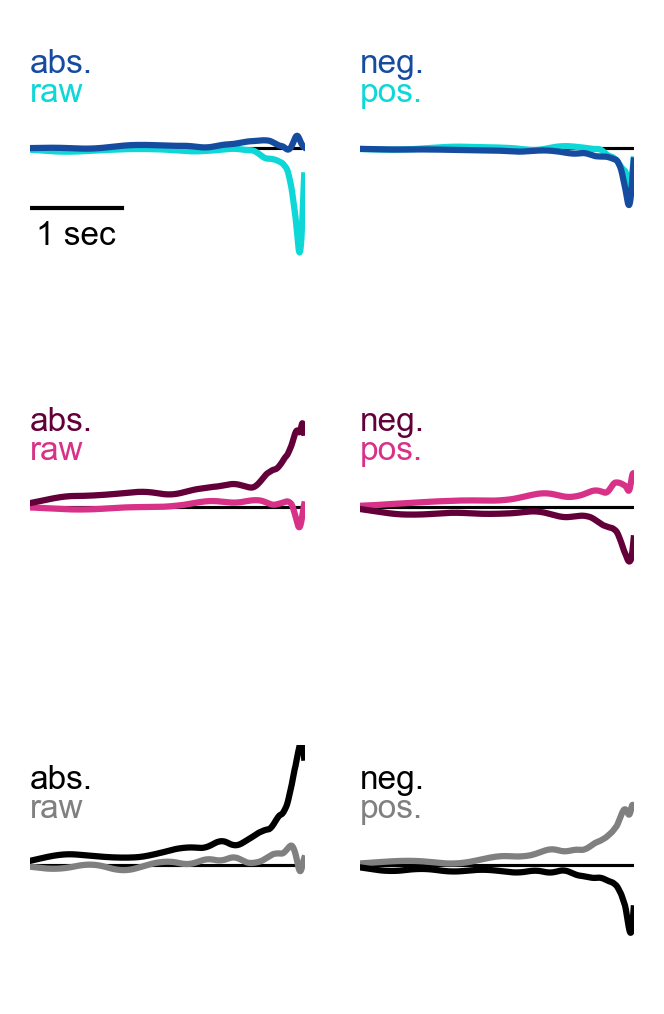

c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


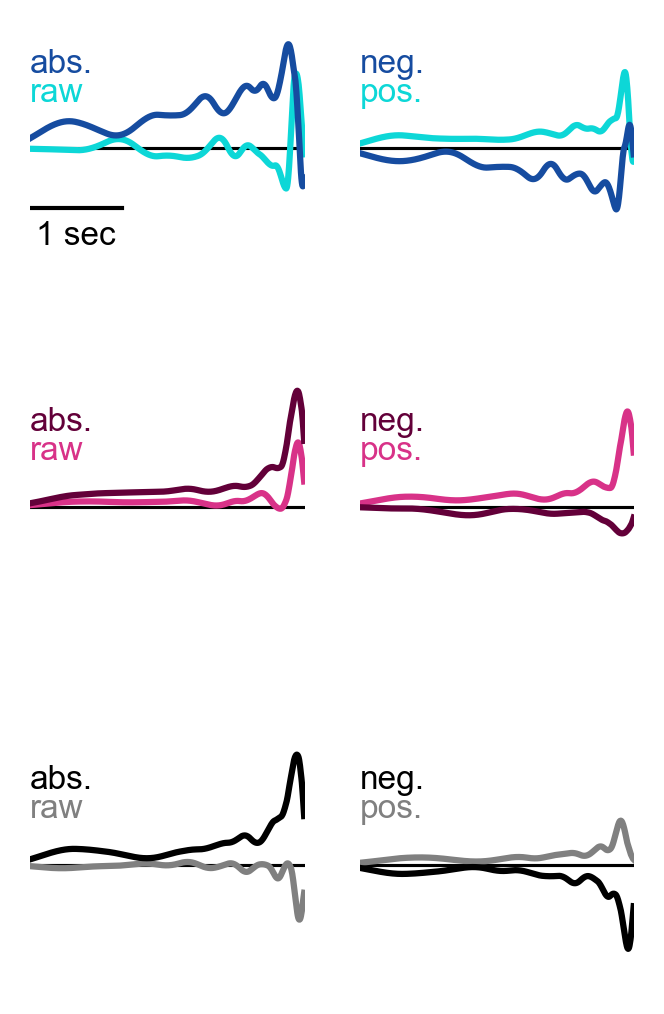

In [7]:
datefolder = f'{results_dir_path}/2025_glms_noZ_fixedbins_linearextrapolation'
filtered_df = df[~((df.DN == 'imposter') & (df.side == 'undefined'))].copy()
filtered_df['DN_specific'] = filtered_df['DN']
filtered_df.loc[filtered_df.DN == 'imposter','DN'] = 'DopaMeander'

filtered_df.loc[filtered_df.DN == 'DopaMeander','DN'] = filtered_df.loc[filtered_df.DN == 'DopaMeander','DN'] + ' ' + filtered_df.loc[filtered_df.DN == 'DopaMeander','side']
filtered_df = filtered_df[filtered_df.DN != 'DopaMeander undefined'].reset_index(drop=True)

variables_linestyle = ['solid','solid'] # ['solid',(0,(5,2))]

DN_list = ['MDN','DopaMeander left','DopaMeander right']
# label_dict = {'v_fwd':r'$v_{fwd}$','abs_v_fwd':r'$|v_{fwd}|$','pos_v_fwd':r'$v_{fwd}^+$','neg_v_fwd':r'$v_{fwd}^-$','v_ang':r'$v_{ang}$','abs_v_ang':r'$|v_{ang}|$','pos_v_ang':r'$v_{ang}^+$','neg_v_ang':r'$v_{ang}^-$'}
label_dict = {'v_fwd':'raw','abs_v_fwd':'abs.','pos_v_fwd':'pos.','neg_v_fwd':'neg.','v_ang':'raw','abs_v_ang':'abs.','pos_v_ang':'pos.','neg_v_ang':'neg.'}
ylims_dict_dict = {'v_fwd':{'DopaMeander left': (-0.25,0.25),'DopaMeander right': (-0.25,0.25), 'MDN': (-0.15,0.15)}, 'v_ang':{'DopaMeander left': (-12,12), 'DopaMeander right': (-12,12), 'MDN': (-1.5,1.5)}}
# ylims_dict_dict = {'v_fwd':{'DopaMeander': (-0.25,0.25), 'MDN': (-0.15,0.15)}, 'v_ang':{'DopaMeander': (-12,12), 'MDN': (-1.5,1.5)}}
# scale_bar_dict = {'v_fwd':{'DopaMeander': (1,0.1), 'MDN': (1,0.05)}, 'v_ang':{'DopaMeander': (1,5), 'MDN': (1,0.5)}}

DN_color_dict = {'MDN': ["#0DD7D7",'#164CA0'], 'DopaMeander left': ['#D83288', "#630039"], 'DopaMeander right': ["grey",'k']}

hspace = 0.5
wspace = 0.2
height_ratios = [1+hspace/3, 1+hspace/3, 1+hspace/3]
width_ratios = [1+wspace/2, 1+wspace/2]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

with open(f'{datefolder}/GLM_filters.pkl', 'rb') as handle:
    estimated_filters_dict = pickle.load(handle)

for veltype in ['v_fwd','v_ang']:
    ylims_dict = ylims_dict_dict[veltype]
    fig,axes = plt.subplots(3,2,figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)

    for jv, variables_list in enumerate([[veltype,f'abs_{veltype}'],[f'pos_{veltype}',f'neg_{veltype}']]):
        for iDN, DN_type in enumerate(DN_list):
            ax = axes[iDN,jv]
            color_list = DN_color_dict[DN_type]

            _plot_filters(ax,lw=1.5,zero_line_lw=0,color_list=color_list)

            # manual legend text
            # if iDN < 2:
            for iv, varname in enumerate(variables_list):
                ax.text(0,0.8+0.12*iv,label_dict[varname],transform=ax.transAxes,ha='left',va='top',color=color_list[iv])

            # scale bar
            if jv == 0 and iDN == 0:
                # scale_number = ylims_dict_dict[veltype][DN_type][1]
                # scale_mag = scale_bar_dict[veltype][DN_type][1]
                # scale_pos = (-3.2,-2*scale_mag)
                # ax.plot([scale_pos[0],scale_pos[0],scale_pos[0]+1],[scale_pos[1]+scale_mag,scale_pos[1],scale_pos[1]],lw=1,color='k')
                # ax.text(scale_pos[0]-0.05,scale_pos[1]+scale_mag*0.5,f'{scale_mag} au',ha='right',va='center',rotation=90)
                # ax.plot([scale_pos[0],scale_pos[0]+1],[scale_pos[1],scale_pos[1]],lw=1,color='k')
                # ax.text(scale_pos[0]+0.5,scale_pos[1]-scale_mag*0.25,'1 sec',ha='center',va='top')
                trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
                ax.plot([-3,-2],[0.25,0.25],lw=1,color='k',transform=trans)
                ax.text(-2.5,0.2,'1 sec',ha='center',va='top',transform=trans)

    for ax in axes.flatten():
        ax.axis("off")
        ax.axhline(0,lw=0.75,color='k',xmin=0,zorder=-1)
        ax.set_xlim([-3,0])
    # plt.savefig(f'fig/{veltype}_filters.pdf', transparent=False, bbox_inches='tight', dpi=300)
    plt.show()

# individual filters

In [8]:
def _plot_filters_individual(filtered_df,ax,lw=2,zero_line_lw=0.25,color_list=None,with_individual_traces=True):

    for iv, varname in enumerate(variables_list):
        filename_list = filtered_df[(filtered_df.DN == DN_type)].filename.tolist()

        # plot_glm_filter(ax=ax,estimated_filters_dict=estimated_filters_dict,filename_list=filename_list,varname=varname,T=T,main_color=color_list[iv],with_l2=False,with_individual_traces=True,linestyle=variables_linestyle[iv],lw=lw,zero_line_lw=zero_line_lw)

        # ax,estimated_filters_dict,filename_list,varname,T,main_color='gray',with_l2=False,with_individual_traces=True,linestyle='-',lw=4,zero_line_lw=0.25
        main_color=color_list[iv]
        with_l2=False
        
        linestyle=variables_linestyle[iv]

        mean_filter_collection = None
        for filename in filename_list:
            if filename in estimated_filters_dict.keys():
                estimated_filters = estimated_filters_dict[filename][varname]

                if with_l2:
                    l2_norms = np.linalg.norm(estimated_filters, ord=2, axis=1)
                    mean_filter = np.nanmean(estimated_filters/l2_norms[:,np.newaxis],axis=0)
                else:
                    mean_filter = np.nanmean(estimated_filters,axis=0)

                if mean_filter_collection is None:
                    mean_filter_collection = mean_filter
                else:
                    mean_filter_collection = np.vstack((mean_filter_collection, mean_filter))

                if with_individual_traces:
                    ax.plot(T, mean_filter, color=main_color,alpha=0.5,lw=1)

            else:
                print(f"{filename} missing")
        ax.axhline(y=0,color='k',lw=zero_line_lw)
        ax.plot(T, np.nanmean(mean_filter_collection,axis=0), color=main_color, lw=lw, linestyle=linestyle)
        # ax.fill_between(T, np.nanmean(mean_filter_collection,axis=0)-(np.nanstd(mean_filter_collection,axis=0)/np.sqrt(mean_filter_collection.shape[0])), np.nanmean(mean_filter_collection,axis=0)+(np.nanstd(mean_filter_collection,axis=0)/np.sqrt(mean_filter_collection.shape[0])), edgecolor=None, facecolor=main_color, alpha=0.5)
        ax.fill_between(T, np.nanmean(mean_filter_collection,axis=0)-(np.nanstd(mean_filter_collection,axis=0)), np.nanmean(mean_filter_collection,axis=0)+(np.nanstd(mean_filter_collection,axis=0)), edgecolor=None, facecolor=main_color, alpha=0.4)
        # ax.plot(T, np.nanmean(mean_filter_collection,axis=0), color=main_color, lw=lw, linestyle=linestyle)

    ylims = ylims_dict[DN_type]
    ax.set_ylim(ylims)
    ax.set_yticks([ylims[0],0,ylims[1]])
    ax.set_yticklabels([ylims[0],0,ylims[1]])

    ax.set_ylabel('Amplitude')
    ax.yaxis.set_label_coords(-0.3, 0.5)

    ax.set_xlim([-3,0]) # 0.025])
    ax.set_xticks([0,-3])
    ax.set_xlabel('Time (s)',labelpad=0)

c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


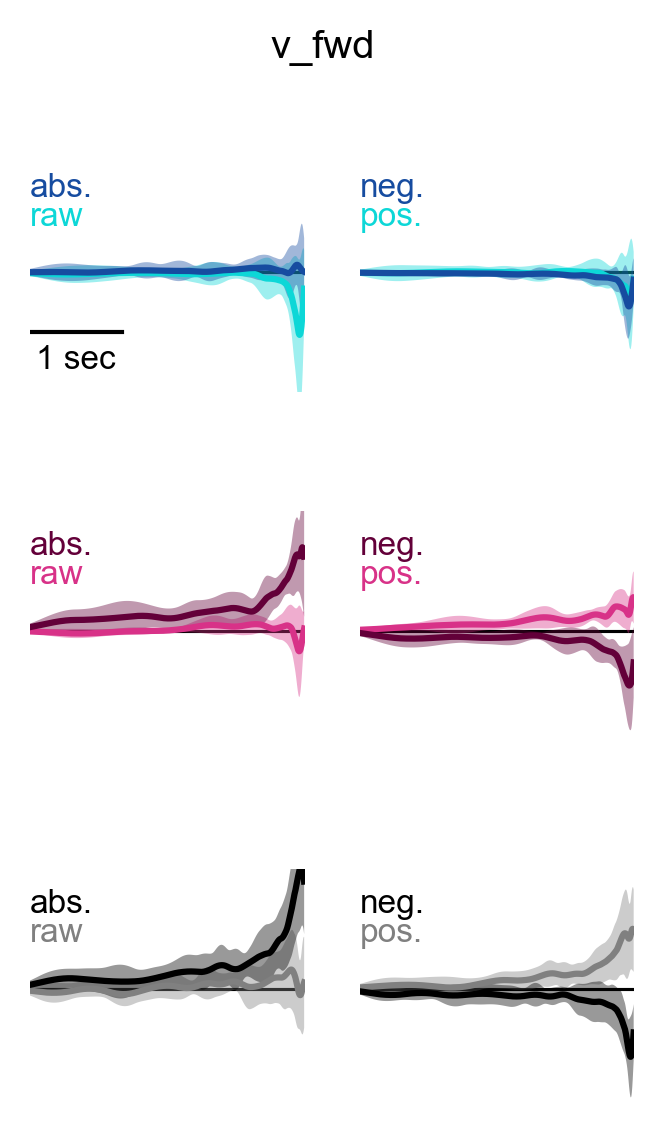

c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


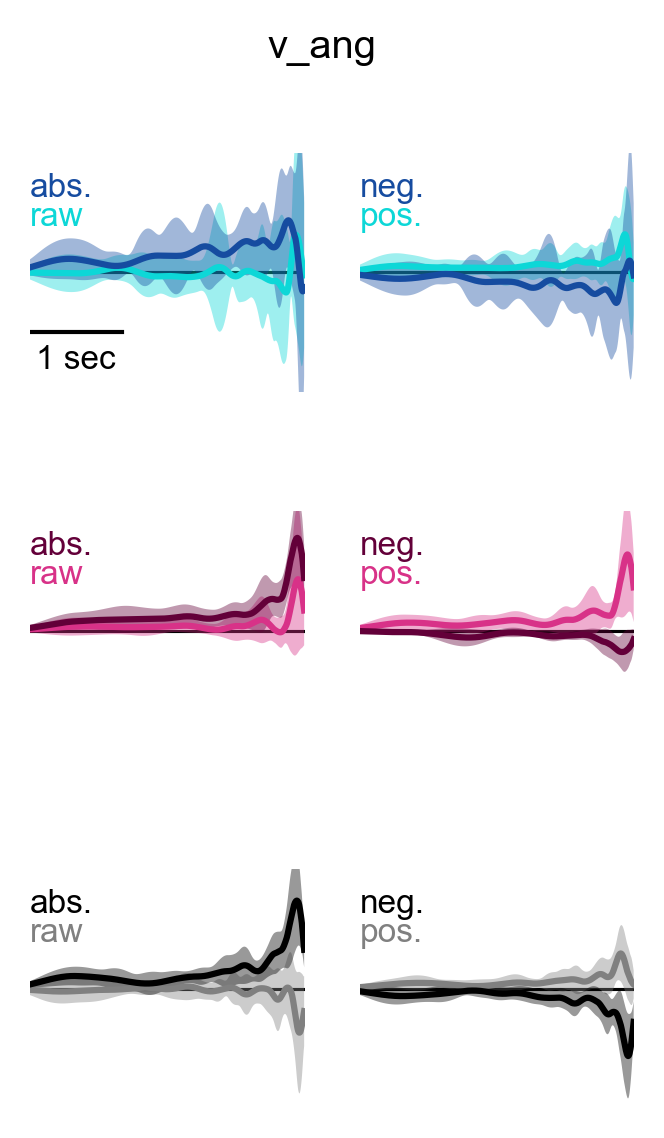

In [9]:
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
filtered_df = df[~((df.DN == 'imposter') & (df.side == 'undefined'))].copy()
filtered_df['DN_specific'] = filtered_df['DN']
filtered_df.loc[filtered_df.DN == 'imposter','DN'] = 'DopaMeander'

filtered_df.loc[filtered_df.DN == 'DopaMeander','DN'] = filtered_df.loc[filtered_df.DN == 'DopaMeander','DN'] + ' ' + filtered_df.loc[filtered_df.DN == 'DopaMeander','side']
filtered_df = filtered_df[filtered_df.DN != 'DopaMeander undefined'].reset_index(drop=True)

variables_linestyle = ['solid','solid'] # ['solid',(0,(5,2))]

DN_list = ['MDN','DopaMeander left','DopaMeander right']
# label_dict = {'v_fwd':r'$v_{fwd}$','abs_v_fwd':r'$|v_{fwd}|$','pos_v_fwd':r'$v_{fwd}^+$','neg_v_fwd':r'$v_{fwd}^-$','v_ang':r'$v_{ang}$','abs_v_ang':r'$|v_{ang}|$','pos_v_ang':r'$v_{ang}^+$','neg_v_ang':r'$v_{ang}^-$'}
label_dict = {'v_fwd':'raw','abs_v_fwd':'abs.','pos_v_fwd':'pos.','neg_v_fwd':'neg.','v_ang':'raw','abs_v_ang':'abs.','pos_v_ang':'pos.','neg_v_ang':'neg.'}
ylims_dict_dict = {'v_fwd':{'DopaMeander left': (-0.25,0.25),'DopaMeander right': (-0.25,0.25), 'MDN': (-0.25,0.25)}, 'v_ang':{'DopaMeander left': (-15,15), 'DopaMeander right': (-15,15), 'MDN': (-3,3)}}
# ylims_dict_dict = {'v_fwd':{'DopaMeander': (-0.25,0.25), 'MDN': (-0.15,0.15)}, 'v_ang':{'DopaMeander': (-12,12), 'MDN': (-1.5,1.5)}}
# scale_bar_dict = {'v_fwd':{'DopaMeander': (1,0.1), 'MDN': (1,0.05)}, 'v_ang':{'DopaMeander': (1,5), 'MDN': (1,0.5)}}

DN_color_dict = {'MDN': ["#0DD7D7",'#164CA0'], 'DopaMeander left': ['#D83288', "#630039"], 'DopaMeander right': ["grey",'k']}

hspace = 0.5
wspace = 0.2
height_ratios = [1+hspace/3, 1+hspace/3, 1+hspace/3]
width_ratios = [1+wspace/2, 1+wspace/2]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

with open(f'{datefolder}/GLM_filters.pkl', 'rb') as handle:
    estimated_filters_dict = pickle.load(handle)

for veltype in ['v_fwd','v_ang']:
    ylims_dict = ylims_dict_dict[veltype]
    fig,axes = plt.subplots(3,2,figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)

    for jv, variables_list in enumerate([[veltype,f'abs_{veltype}'],[f'pos_{veltype}',f'neg_{veltype}']]):
        for iDN, DN_type in enumerate(DN_list):
            ax = axes[iDN,jv]
            color_list = DN_color_dict[DN_type]

            _plot_filters_individual(filtered_df,ax,lw=1.5,zero_line_lw=0,color_list=color_list,with_individual_traces=False)

            # manual legend text
            # if iDN < 2:
            for iv, varname in enumerate(variables_list):
                ax.text(0,0.8+0.12*iv,label_dict[varname],transform=ax.transAxes,ha='left',va='top',color=color_list[iv])

            # scale bar
            if jv == 0 and iDN == 0:
                # scale_number = ylims_dict_dict[veltype][DN_type][1]
                # scale_mag = scale_bar_dict[veltype][DN_type][1]
                # scale_pos = (-3.2,-2*scale_mag)
                # ax.plot([scale_pos[0],scale_pos[0],scale_pos[0]+1],[scale_pos[1]+scale_mag,scale_pos[1],scale_pos[1]],lw=1,color='k')
                # ax.text(scale_pos[0]-0.05,scale_pos[1]+scale_mag*0.5,f'{scale_mag} au',ha='right',va='center',rotation=90)
                # ax.plot([scale_pos[0],scale_pos[0]+1],[scale_pos[1],scale_pos[1]],lw=1,color='k')
                # ax.text(scale_pos[0]+0.5,scale_pos[1]-scale_mag*0.25,'1 sec',ha='center',va='top')
                trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
                ax.plot([-3,-2],[0.25,0.25],lw=1,color='k',transform=trans)
                ax.text(-2.5,0.2,'1 sec',ha='center',va='top',transform=trans)

    for ax in axes.flatten():
        ax.axis("off")
        ax.axhline(0,lw=0.75,color='k',xmin=0,zorder=-1)
        ax.set_xlim([-3,0])
    plt.suptitle(veltype)
    # plt.savefig(f'fig/{veltype}_STD_filters.png', transparent=False, bbox_inches='tight', dpi=300)
    plt.show()

# Boxplots

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:99: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=False,legend=False,size=2,edgecolor='none',linewidth=0.5)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:99: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=False,legend=False,size=2,edgecolor='none',linewidth=0.5)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compat

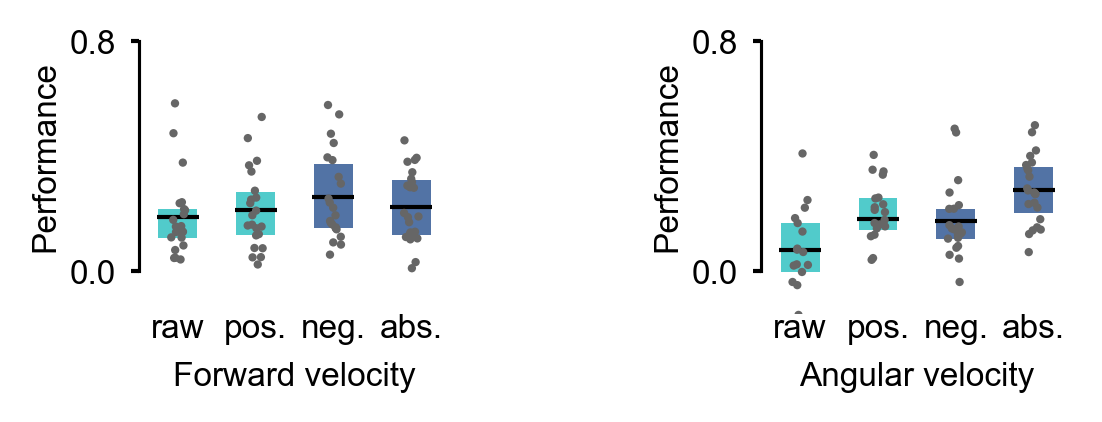

In [10]:
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot['DN_specific'] = df_plot['DN']
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
df_plot = df_plot[df_plot.DN != 'DopaMeander undefined'].reset_index(drop=True)

label_dict = {'v_fwd':'raw','abs_v_fwd':'abs.','pos_v_fwd':'pos.','neg_v_fwd':'neg.','v_ang':'raw','abs_v_ang':'abs.','pos_v_ang':'pos.','neg_v_ang':'neg.'}

# DN_color_dict = {'MDN': ["#0DD7D7",'#164CA0'], 'DopaMeander left': ['#D83288', "#630039"], 'DopaMeander right': ["grey",'k']}

DN_list_order = ['MDN']
MDN_colors = {'v_fwd': "#0DD7D7", 'abs_v_fwd': "#164CA0", 'pos_v_fwd': "#0DD7D7", 'neg_v_fwd': "#164CA0",'v_ang': "#0DD7D7", 'abs_v_ang': "#164CA0", 'pos_v_ang': "#0DD7D7", 'neg_v_ang': "#164CA0"}
ylims = [0,0.8]
hspace = 0
wspace = 1
height_ratios = [1]
width_ratios = [1.2+wspace/2, 1.2+wspace/2]

gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)
color_palette = MDN_colors

fig,axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
for iv, veltype, xlabel in zip(range(2),['v_fwd','v_ang'],['Forward velocity','Angular velocity']):

    variables_list = [veltype, f'pos_{veltype}', f'neg_{veltype}', f'abs_{veltype}']
    for DN in DN_list_order:
        ax = axes[iv]
        _plot_bars(ax, df_plot=df_plot, xlabel=xlabel, ylims=ylims, color_palette=color_palette, stripcolor_palette=['#666666'], alpha_stripplot=1)
        ax.spines['bottom'].set_visible(False)
        # ax.spines['bottom'].set_position(('outward', 0))  # to space spine from plot
        ax.set_ylim([ylims[0]-0.15,ylims[1]])
        ax.spines[['left']].set_bounds(ylims)

# plt.savefig(f'fig/bar_scores.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:99: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=False,legend=False,size=2,edgecolor='none',linewidth=0.5)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:99: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=False,legend=False,size=2,edgecolor='none',linewidth=0.5)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compat

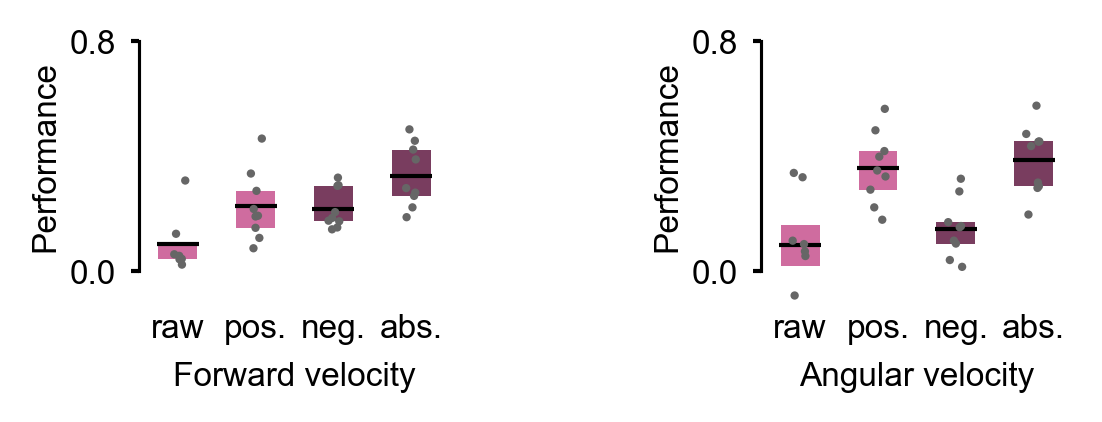

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:99: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=False,legend=False,size=2,edgecolor='none',linewidth=0.5)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:99: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=False,legend=False,size=2,edgecolor='none',linewidth=0.5)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compat

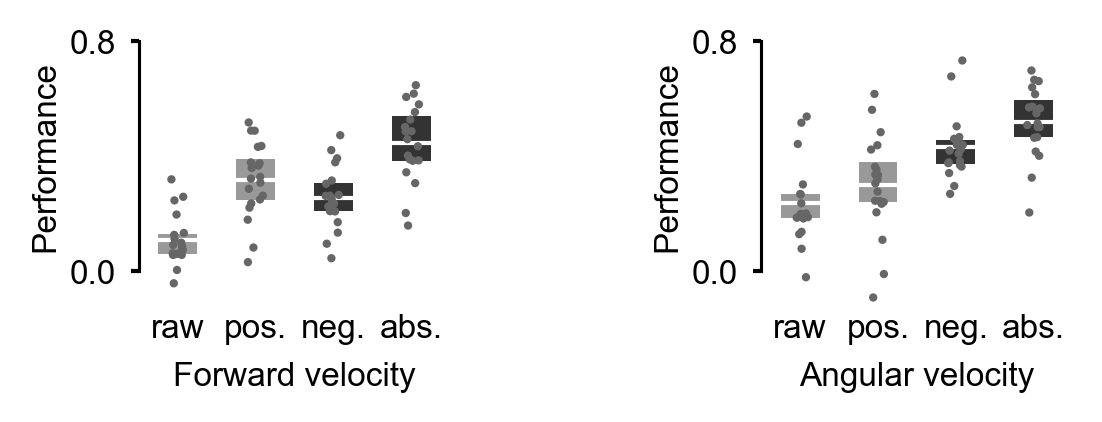

In [11]:
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot['DN_specific'] = df_plot['DN']
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
df_plot = df_plot[df_plot.DN != 'DopaMeander undefined'].reset_index(drop=True)

# DN_color_dict = {'MDN': ["#0DD7D7",'#164CA0'], 'DopaMeander left': ['#D83288', "#630039"], 'DopaMeander right': ["grey",'k']}

label_dict = {'v_fwd':'raw','abs_v_fwd':'abs.','pos_v_fwd':'pos.','neg_v_fwd':'neg.','v_ang':'raw','abs_v_ang':'abs.','pos_v_ang':'pos.','neg_v_ang':'neg.'}
DML_colors = {'v_fwd': "#D83288", 'abs_v_fwd': "#630039", 'pos_v_fwd': "#D83288", 'neg_v_fwd': "#630039",'v_ang': "#D83288", 'abs_v_ang': "#630039", 'pos_v_ang': "#D83288", 'neg_v_ang': "#630039"}
DMR_colors = {'v_fwd': "grey", 'abs_v_fwd': "k", 'pos_v_fwd': "grey", 'neg_v_fwd': "k",'v_ang': "grey", 'abs_v_ang': "k", 'pos_v_ang': "grey", 'neg_v_ang': "k"}
ylims = [0,0.8]
hspace = 0
wspace = 1
height_ratios = [1]
width_ratios = [1.2+wspace/2, 1.2+wspace/2]

gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

for side, color_palette, marker_color in zip(['left','right'],[DML_colors,DMR_colors],['k','w']):
    DN = f"DopaMeander {side}"
    fig,axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
    for iv, veltype, xlabel in zip(range(2),['v_fwd','v_ang'],['Forward velocity','Angular velocity']):
        variables_list = [veltype, f'pos_{veltype}', f'neg_{veltype}', f'abs_{veltype}']

        ax = axes[iv]
        _plot_bars(ax, df_plot=df_plot, xlabel=xlabel, ylims=ylims, color_palette=color_palette, stripcolor_palette=['#666666'], marker_color=marker_color, alpha_stripplot=1)
        ax.spines['bottom'].set_visible(False)
        # ax.spines['bottom'].set_position(('outward', 0))  # to space spine from plot
        ax.set_ylim([ylims[0]-0.15,ylims[1]])
        ax.spines[['left']].set_bounds(ylims)

    # plt.savefig(f'fig/bar_scores_DM_{side}.pdf', transparent=False, bbox_inches='tight', dpi=300)
    plt.show()

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:114: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=boxcolor_palette, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 8, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5}, medianprops={"visible": False}, width=0.75)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:130: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=True,lege

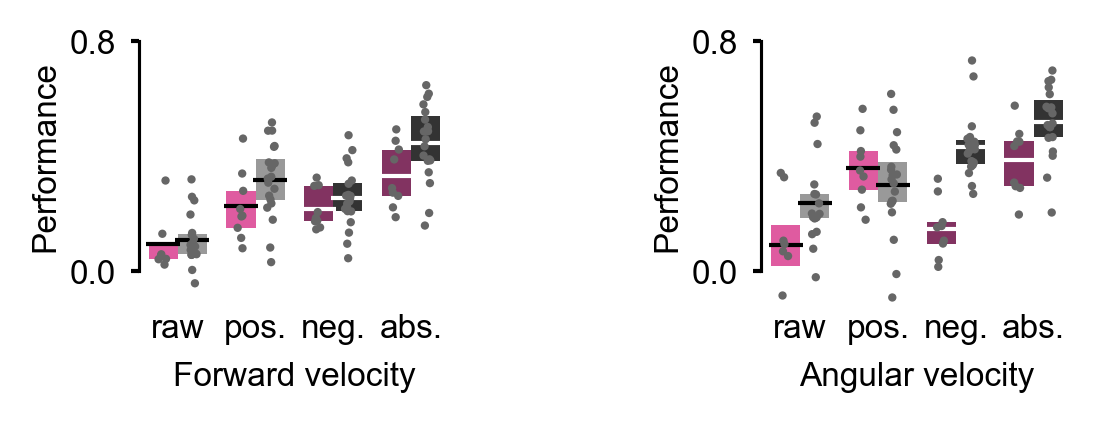

In [12]:


datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot['DN_specific'] = df_plot['DN']
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot = df_plot[~((df_plot.DN == 'DopaMeander')&(df_plot.DN_side == 'undefined'))].reset_index(drop=True)

# DN_color_dict = {'MDN': ["#0DD7D7",'#164CA0'], 'DopaMeander left': ['#D83288', "#630039"], 'DopaMeander right': ["grey",'k']}
label_dict = {'v_fwd':'raw','abs_v_fwd':'abs.','pos_v_fwd':'pos.','neg_v_fwd':'neg.','v_ang':'raw','abs_v_ang':'abs.','pos_v_ang':'pos.','neg_v_ang':'neg.'}
DML_colors = {'v_fwd': "#D83288", 'abs_v_fwd': "#630039", 'pos_v_fwd': "#D83288", 'neg_v_fwd': "#630039",'v_ang': "#D83288", 'abs_v_ang': "#630039", 'pos_v_ang': "#D83288", 'neg_v_ang': "#630039"}
DMR_colors = {'v_fwd': "k", 'abs_v_fwd': "grey", 'pos_v_fwd': "k", 'neg_v_fwd': "grey",'v_ang': "k", 'abs_v_ang': "grey", 'pos_v_ang': "k", 'neg_v_ang': "grey"}

ylims = [0,0.8]
hspace = 0
wspace = 1
height_ratios = [1]
width_ratios = [1.2+wspace/2, 1.2+wspace/2]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

DN = "DopaMeander"
stripcolor_palette = ["#D83288", "grey", "#D83288", "grey", "#630039", "k", "#630039", "k"]
boxcolor_palette = ["#D83288", "#D83288", "#630039", "#630039", "grey", "grey", "k", "k"]
fig,axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
for iv, veltype, xlabel in zip(range(2),['v_fwd','v_ang'],['Forward velocity','Angular velocity']):
    variables_list = [veltype, f'pos_{veltype}', f'neg_{veltype}', f'abs_{veltype}']

    ax = axes[iv]
    _plot_bars_DM(ax, df_plot=df_plot, xlabel=xlabel, ylims=ylims, stripcolor_palette=['#666666'],boxcolor_palette=boxcolor_palette, alpha_stripplot=1)
    ax.spines['bottom'].set_visible(False)
    # ax.spines['bottom'].set_position(('outward', 0))  # to space spine from plot
    ax.set_ylim([ylims[0]-0.15,ylims[1]])
    ax.spines[['left']].set_bounds(ylims)

# plt.savefig(f'fig/bar_scores_DM.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# print variances

In [13]:
datefolder = f'{results_dir_path}/2025_glms_noZ_fixedbins_linearextrapolation'
datadf_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
datadf_plot['DN_specific'] = datadf_plot['DN']
datadf_plot.loc[datadf_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot = datadf_plot[~((datadf_plot.DN == 'DopaMeander')&(datadf_plot.DN_side == 'undefined'))].reset_index(drop=True)


res = df_plot[(df_plot.DN.isin(['DopaMeander','MDN']))&(~df_plot.pearsonr_score.isna())].groupby(['DN','DN_side','varname'])['pearsonr_score'].agg(['mean','std']).reset_index().rename(columns={'DN':'Neuron','mean':'Average variance explained','DN_side':'Side','std':'Standard deviation'})
res['Velocity'] = ['Forward' if 'fwd' in vv else 'Angular' for vv in res['varname']]
complist = []
for vv in res['varname']:
    if 'abs' in vv:
        complist.append('Absolute')
    elif 'neg' in vv:
        complist.append('Negative')
    elif 'pos' in vv:
        complist.append('Positive')
    else:
        complist.append('Unprocessed')
res['Component'] = complist
res = res[['Neuron','Side','Velocity','Component','Average variance explained','Standard deviation']]
display(res)
tsv_string = res.to_csv(sep='\t', index=False)
tsv_string

,Neuron,Side,Velocity,Component,Average variance explained,Standard deviation
0,DopaMeander,left,Angular,Absolute,0.388611,0.120584
1,DopaMeander,left,Forward,Absolute,0.330798,0.108130
2,DopaMeander,left,Angular,Negative,0.145380,0.100129
3,DopaMeander,left,Forward,Negative,0.217904,0.070101
4,DopaMeander,left,Angular,Positive,0.366012,0.123833
5,DopaMeander,left,Forward,Positive,0.225576,0.118734
6,DopaMeander,left,Angular,Unprocessed,0.091277,0.180595
7,DopaMeander,left,Forward,Unprocessed,0.096126,0.101142
8,DopaMeander,right,Angular,Absolute,0.520832,0.124462
9,DopaMeander,right,Forward,Absolute,0.444687,0.134156


'Neuron\tSide\tVelocity\tComponent\tAverage variance explained\tStandard deviation\r\nDopaMeander\tleft\tAngular\tAbsolute\t0.3886114608705222\t0.12058413943230169\r\nDopaMeander\tleft\tForward\tAbsolute\t0.3307980696607256\t0.10812968746629008\r\nDopaMeander\tleft\tAngular\tNegative\t0.14537996660626376\t0.10012881737075421\r\nDopaMeander\tleft\tForward\tNegative\t0.21790418768038686\t0.07010085093385132\r\nDopaMeander\tleft\tAngular\tPositive\t0.36601224483112793\t0.1238329371667962\r\nDopaMeander\tleft\tForward\tPositive\t0.2255759107758074\t0.11873393347445556\r\nDopaMeander\tleft\tAngular\tUnprocessed\t0.09127661720408903\t0.18059451377209432\r\nDopaMeander\tleft\tForward\tUnprocessed\t0.09612625533317277\t0.10114198774926414\r\nDopaMeander\tright\tAngular\tAbsolute\t0.5208321537354411\t0.12446244934554325\r\nDopaMeander\tright\tForward\tAbsolute\t0.44468661850116115\t0.13415599816582335\r\nDopaMeander\tright\tAngular\tNegative\t0.4344928155819268\t0.11395907070187038\r\nDopaMeand

In [14]:
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
datadf_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
datadf_plot['DN_specific'] = datadf_plot['DN']
datadf_plot.loc[datadf_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot = datadf_plot[~((datadf_plot.DN == 'DopaMeander')&(datadf_plot.DN_side == 'undefined'))].reset_index(drop=True)


res2 = df_plot[(df_plot.DN.isin(['DopaMeander','MDN']))&(~df_plot.pearsonr_score.isna())].groupby(['DN','DN_side','varname'])['pearsonr_score'].agg(['mean','std']).reset_index().rename(columns={'DN':'Neuron','mean':'Average variance explained','DN_side':'Side','std':'Standard deviation'})
res2['Velocity'] = ['Forward' if 'fwd' in vv else 'Angular' for vv in res2['varname']]
complist = []
for vv in res2['varname']:
    if 'abs' in vv:
        complist.append('Absolute')
    elif 'neg' in vv:
        complist.append('Negative')
    elif 'pos' in vv:
        complist.append('Positive')
    else:
        complist.append('Unprocessed')
res2['Component'] = complist
res2 = res2[['Neuron','Side','Velocity','Component','Average variance explained','Standard deviation']]
display(res2.round(3))
tsv_string = res2.to_csv(sep='\t', index=False)
tsv_string

,Neuron,Side,Velocity,Component,Average variance explained,Standard deviation
0,DopaMeander,left,Angular,Absolute,0.387,0.120
1,DopaMeander,left,Forward,Absolute,0.332,0.109
2,DopaMeander,left,Angular,Negative,0.148,0.101
3,DopaMeander,left,Forward,Negative,0.217,0.070
4,DopaMeander,left,Angular,Positive,0.359,0.124
5,DopaMeander,left,Forward,Positive,0.225,0.119
6,DopaMeander,left,Angular,Unprocessed,0.090,0.181
7,DopaMeander,left,Forward,Unprocessed,0.095,0.103
8,DopaMeander,right,Angular,Absolute,0.518,0.123
9,DopaMeander,right,Forward,Absolute,0.446,0.134


'Neuron\tSide\tVelocity\tComponent\tAverage variance explained\tStandard deviation\r\nDopaMeander\tleft\tAngular\tAbsolute\t0.38660710291381173\t0.11970476524278514\r\nDopaMeander\tleft\tForward\tAbsolute\t0.33232958329220624\t0.10931898559627422\r\nDopaMeander\tleft\tAngular\tNegative\t0.14801033205090453\t0.10104849604253595\r\nDopaMeander\tleft\tForward\tNegative\t0.21735604287156135\t0.06980686359337848\r\nDopaMeander\tleft\tAngular\tPositive\t0.35930645802095573\t0.12378297533601444\r\nDopaMeander\tleft\tForward\tPositive\t0.22486651377804603\t0.11885652693253622\r\nDopaMeander\tleft\tAngular\tUnprocessed\t0.08960209940687971\t0.1807018459168471\r\nDopaMeander\tleft\tForward\tUnprocessed\t0.09457049213056958\t0.10306803774055165\r\nDopaMeander\tright\tAngular\tAbsolute\t0.51785158783377\t0.12346461637307565\r\nDopaMeander\tright\tForward\tAbsolute\t0.4458005029051865\t0.13403864372565338\r\nDopaMeander\tright\tAngular\tNegative\t0.4314888067387443\t0.1130004498412231\r\nDopaMeande

In [15]:
res2['Average variance explained']-res['Average variance explained']

0    -0.002004
1     0.001532
2     0.002630
3    -0.000548
4    -0.006706
5    -0.000709
6    -0.001675
7    -0.001556
8    -0.002981
9     0.001114
10   -0.003004
11   -0.000415
12   -0.000095
13    0.000826
14   -0.002084
15   -0.000284
16    0.000616
17   -0.000350
18    0.002197
19   -0.000129
20    0.005012
21    0.003213
22   -0.000844
23   -0.006914
Name: Average variance explained, dtype: float64

In [16]:
res2.set_index(['Neuron','Side','Velocity','Component']).sort_index(level=[0,1,2,3]).round(2)

Average variance explained  \
Neuron      Side      Velocity Component                                 
DopaMeander left      Angular  Absolute                           0.39   
                               Negative                           0.15   
                               Positive                           0.36   
                               Unprocessed                        0.09   
                      Forward  Absolute                           0.33   
                               Negative                           0.22   
                               Positive                           0.22   
                               Unprocessed                        0.09   
            right     Angular  Absolute                           0.52   
                               Negative                           0.43   
                               Positive                           0.30   
                               Unprocessed                        0.24   
                      Forward  Absolute                           0.45   
                               Negative                           0.26   
                               Positive                           0.32   
                               Unprocessed                        0.11   
MDN         undefined Angular  Absolute                           0.28   
                               Negative                           0.18   
                               Positive                           0.18   
                               Unprocessed                        0.07   
                      Forward  Absolute                           0.22   
                               Negative                           0.26   
                               Positive                           0.21   
                               Unprocessed                        0.19   

                                            Standard deviation  
Neuron      Side      Velocity Component                        
DopaMeander left      Angular  Absolute                   0.12  
                               Negative                   0.10  
                               Positive                   0.12  
                               Unprocessed                0.18  
                      Forward  Absolute                   0.11  
                               Negative                   0.07  
                               Positive                   0.12  
                               Unprocessed                0.10  
            right     Angular  Absolute                   0.12  
                               Negative                   0.11  
                               Positive                   0.17  
                               Unprocessed                0.15  
                      Forward  Absolute                   0.13  
                               Negative                   0.11  
                               Positive                   0.13  
                               Unprocessed                0.09  
MDN         undefined Angular  Absolute                   0.12  
                               Negative                   0.13  
                               Positive                   0.16  
                               Unprocessed                0.15  
                      Forward  Absolute                   0.12  
                               Negative                   0.15  
                               Positive                   0.14  
                               Unprocessed                0.14

# Boxplots with p-values

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:99: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=False,legend=False,size=2,edgecolor='none',linewidth=0.5)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\2809833247.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_df = pd.concat((pv_df,pd.DataFrame([[pair[0], pair[1], panel_letters[iv], 'tbi', ps, corrected_ps]], columns=['Group 1', 'Group 2', 'Panel','Test','p','p (bonf corrected)'])))
C:\Users\apalaci\AppData

using mannwhitneyu
using ttest_ind
using ttest_ind
D (0, 2) 0.08673064464371182 0.26019193393113543
D (2, 3) 0.3978302631665509 1.1934907894996527
D (1, 2) 0.3026154235288633 0.9078462705865898
using ttest_ind
using mannwhitneyu
using mannwhitneyu
F (0, 3) 3.754735822695397e-05 0.00011264207468086191
F (1, 3) 0.022806912046340257 0.06842073613902078
F (2, 3) 0.002844064631583789 0.008532193894751367
using ttest_ind
using ttest_ind
using mannwhitneyu
using ttest_ind
H (2, 4) 0.8726826481172596 3.4907305924690384
H (3, 5) 0.10592156797610473 0.42368627190441893
H (0, 6) 0.003321678321678322 0.013286713286713287
H (1, 7) 2.498815588853201e-10 9.995262355412804e-10


C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:114: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=boxcolor_palette, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 8, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5}, medianprops={"visible": False}, width=0.75)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1915034850.py:130: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=hue_order, palette=stripcolor_palette, ax=ax,alpha=alpha_stripplot,dodge=True,lege

using ttest_ind
using mannwhitneyu
using ttest_ind
using ttest_ind
J (2, 4) 0.0011854301389609204 0.0047417205558436815
J (3, 5) 0.003636332646051064 0.014545330584204257
J (0, 6) 0.001971611106952176 0.007886444427808705
J (1, 7) 7.06666198077456e-07 2.826664792309824e-06


c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


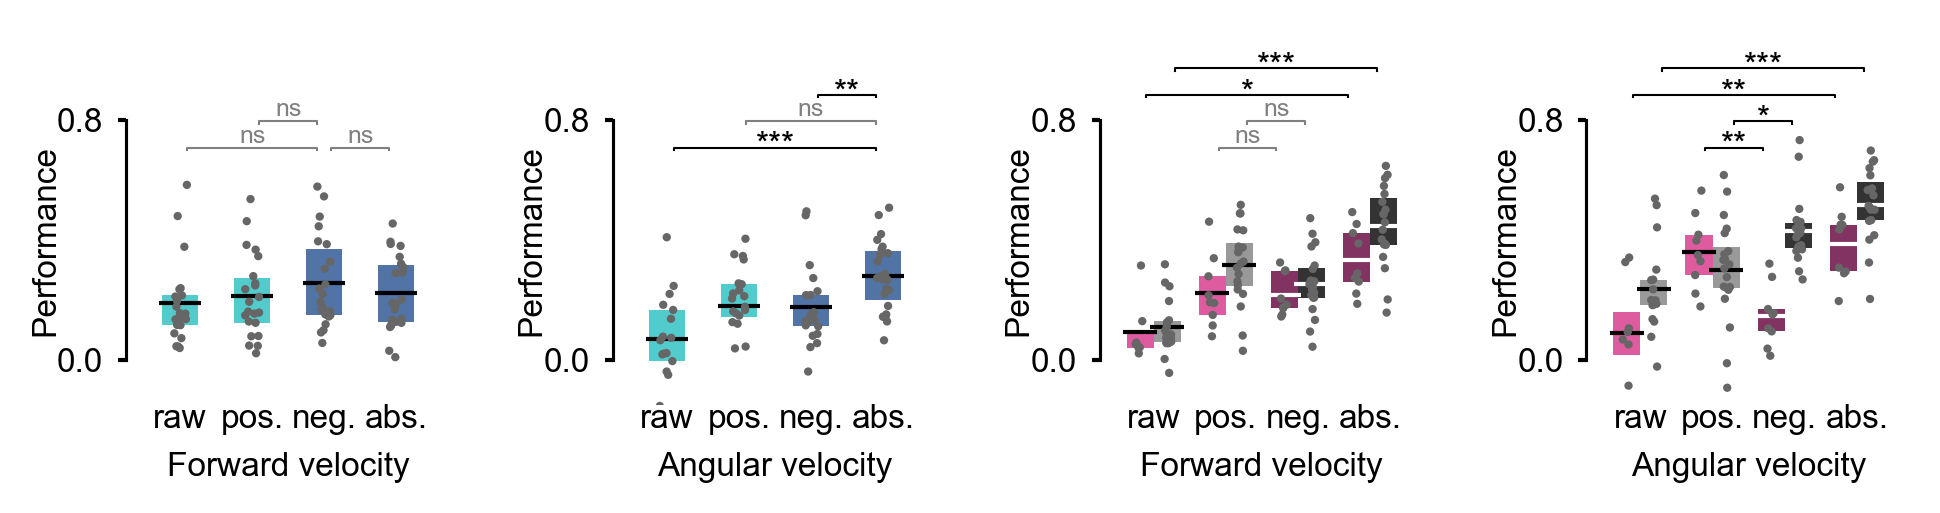

In [17]:
pairs_tested_list = [[(0,2),(2,3),(1,2)], [(0,3),(1,3),(2,3)], [(2,4),(3,5),(0,6),(1,7)], [(2,4),(3,5),(0,6),(1,7)]]
# hlevels_list = [[0,0,1], [0,1,2], [0,1,2,3], [0,1,2,3]]
hlevels_list = [[0,0,1], [0,1,2], [0,1,2,3], [0,1,2,3]]
# pmin_lines [0.7,0.7,0.7,0.7]

datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'
datadf_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
datadf_plot['DN_specific'] = datadf_plot['DN']
datadf_plot.loc[datadf_plot.DN == 'imposter','DN'] = 'DopaMeander'

df_plot = datadf_plot[~((datadf_plot.DN == 'DopaMeander')&(datadf_plot.DN_side == 'undefined'))].reset_index(drop=True)

label_dict = {'v_fwd':'raw','abs_v_fwd':'abs.','pos_v_fwd':'pos.','neg_v_fwd':'neg.','v_ang':'raw','abs_v_ang':'abs.','pos_v_ang':'pos.','neg_v_ang':'neg.'}
MDN_colors = {'v_fwd': "#0DD7D7", 'abs_v_fwd': "#164CA0", 'pos_v_fwd': "#0DD7D7", 'neg_v_fwd': "#164CA0",'v_ang': "#0DD7D7", 'abs_v_ang': "#164CA0", 'pos_v_ang': "#0DD7D7", 'neg_v_ang': "#164CA0"}
DML_colors = {'v_fwd': "#D83288", 'abs_v_fwd': "#630039", 'pos_v_fwd': "#D83288", 'neg_v_fwd': "#630039",'v_ang': "#D83288", 'abs_v_ang': "#630039", 'pos_v_ang': "#D83288", 'neg_v_ang': "#630039"}
DMR_colors = {'v_fwd': "k", 'abs_v_fwd': "grey", 'pos_v_fwd': "k", 'neg_v_fwd': "grey",'v_ang': "k", 'abs_v_ang': "grey", 'pos_v_ang': "k", 'neg_v_ang': "grey"}

ylims = [0,0.8]
hspace = 0
wspace = 0.5
height_ratios = [1.375]
width_ratios = [1.5+wspace/4, 1.5+wspace/4, 1.5+wspace/4, 1.5+wspace/4]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

pv_df = pd.DataFrame(columns=['Group 1', 'Group 2', 'Panel','Test','p','p (bonf corrected)'])
panel_letters = ['D','F','H','J']

fig,axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
for iv, DN, veltype, xlabel, pairs_tested, hlevels in zip(range(4),["MDN","MDN","DopaMeander","DopaMeander"],['v_fwd','v_ang','v_fwd','v_ang'],['Forward velocity','Angular velocity','Forward velocity','Angular velocity'],pairs_tested_list,hlevels_list):
    variables_list = [veltype, f'pos_{veltype}', f'neg_{veltype}', f'abs_{veltype}']

    ax = axes[iv]

    if DN == 'DopaMeander':
        df_plot = datadf_plot[~((datadf_plot.DN == 'DopaMeander')&(datadf_plot.DN_side == 'undefined'))].reset_index(drop=True)
        stripcolor_palette = ["#D83288", "grey", "#D83288", "grey", "#630039", "k", "#630039", "k"]
        boxcolor_palette = ["#D83288", "#D83288", "#630039", "#630039", "grey", "grey", "k", "k"]
        _plot_bars_DM(ax, df_plot=df_plot, xlabel=xlabel, ylims=ylims, stripcolor_palette=['#666666'],boxcolor_palette=boxcolor_palette,alpha_stripplot=1)
        grouped_data = [df_plot[(df_plot.DN_side == hue)&(df_plot.DN == DN)&(df_plot.varname == varname)&(~df_plot.pearsonr_score.isna())]['pearsonr_score'].tolist() for varname in variables_list for hue in ['left','right']]
        data_xpos = np.asarray([-0.2,0.2,0.8,1.2,1.8,2.2,2.8,3.2])
        hierarchy_shift = ylims[1]*0.11
        pv_line_min = ylims[1]*0.9
    elif DN == 'MDN':
        df_plot = datadf_plot.reset_index(drop=True)
        color_palette = MDN_colors
        _plot_bars(ax, df_plot=df_plot, xlabel=xlabel, ylims=ylims, color_palette=color_palette,stripcolor_palette=['#666666'],alpha_stripplot=1)
        grouped_data = [df_plot[(df_plot.DN == DN)&(df_plot.varname == varname)&(~df_plot.pearsonr_score.isna())]['pearsonr_score'].tolist() for varname in variables_list]
        data_xpos = np.asarray([0,1,2,3])
        hierarchy_shift = ylims[1]*0.11
        pv_line_min = ylims[1]*0.85

    p_array = np.asarray([compare_pair([grouped_data[igroup] for igroup in pair],verbose=True) for pair in pairs_tested])
    corrected_p_array = p_array.shape[0]*p_array
    for pair, ps, corrected_ps in zip(pairs_tested, p_array, corrected_p_array):
        print(panel_letters[iv], pair, ps, corrected_ps)
        pv_df = pd.concat((pv_df,pd.DataFrame([[pair[0], pair[1], panel_letters[iv], 'tbi', ps, corrected_ps]], columns=['Group 1', 'Group 2', 'Panel','Test','p','p (bonf corrected)'])))
    add_pv_extra_explicit(corrected_p_array,grouped_data,data_xpos=data_xpos,pairs_tested=pairs_tested,hierarchy_levels=hlevels,hierarchy_shift=hierarchy_shift,pv_marker_width=ylims[1]*0.01,pv_line_min=0.7,ax=ax,numbers_fontsize=6,explicit_pvs=False,explicit_ns=False,asterisk_fontsize=8,ignore_ns=False,padding=0.1,line_lw=0.5)
    
    ax.spines['bottom'].set_visible(False)
    ax.set_ylim([ylims[0]-0.15,ylims[1]+0.3])
    ax.spines[['left']].set_bounds(ylims)
    ax.set_xlim([-0.75,3.75])

    trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.yaxis.set_label_coords(-0.2, (ylims[1]-ylims[0])/2,transform=trans)

plt.savefig(f'fig/bar_scores_pvalues_asterisks.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [18]:
pv_df['Test'] = ['mannwhitneyu','ttest','ttest','ttest','mannwhitneyu','mannwhitneyu','mannwhitneyu','ttest','mannwhitneyu','ttest','ttest','mannwhitneyu','ttest','ttest']
pv_df.loc[pv_df['p (bonf corrected)']>1, 'p (bonf corrected)'] = 1

pv_df = pv_df.style.format({'p': "{:.2E}",'p (bonf corrected)': "{:.2e}"})
pv_df

,Group 1,Group 2,Panel,Test,p,p (bonf corrected)
0,0,2,D,mannwhitneyu,8.67E-02,2.60e-01
0,2,3,D,ttest,3.98E-01,1.00e+00
0,1,2,D,ttest,3.03E-01,9.08e-01
0,0,3,F,ttest,3.75E-05,1.13e-04
0,1,3,F,mannwhitneyu,2.28E-02,6.84e-02
0,2,3,F,mannwhitneyu,2.84E-03,8.53e-03
0,2,4,H,mannwhitneyu,8.73E-01,1.00e+00
0,3,5,H,ttest,1.06E-01,4.24e-01
0,0,6,H,mannwhitneyu,3.32E-03,1.33e-02
0,1,7,H,ttest,2.50E-10,1.00e-09


In [19]:
datefolder = f'{results_dir_path}/2025_glms_noZ_fixedbins_linearextrapolation'
datadf_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
datadf_plot['DN_specific'] = datadf_plot['DN']
datadf_plot.loc[datadf_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot = datadf_plot[~((datadf_plot.DN == 'DopaMeander')&(datadf_plot.DN_side == 'undefined'))].reset_index(drop=True)

DN = 'DopaMeander'
veltype= 'v_ang'
variables_list = [veltype, f'pos_{veltype}', f'neg_{veltype}', f'abs_{veltype}']
df_plot = datadf_plot.reset_index(drop=True)
# print( [np.nanmean(df_plot[(df_plot.DN == DN)&(df_plot.varname == varname)&(~df_plot.pearsonr_score.isna())]['pearsonr_score'].tolist()) for varname in variables_list])
# print( [np.nanstd(df_plot[(df_plot.DN == DN)&(df_plot.varname == varname)&(~df_plot.pearsonr_score.isna())]['pearsonr_score'].tolist()) for varname in variables_list])

print( [np.nanmean(df_plot[(df_plot.DN_side == hue)&(df_plot.DN == DN)&(df_plot.varname == varname)&(~df_plot.pearsonr_score.isna())]['pearsonr_score'].tolist()) for varname in variables_list for hue in ['left','right']])
print( [np.nanstd(df_plot[(df_plot.DN_side == hue)&(df_plot.DN == DN)&(df_plot.varname == varname)&(~df_plot.pearsonr_score.isna())]['pearsonr_score'].tolist()) for varname in variables_list for hue in ['left','right']])


[np.float64(0.09127661720408903), np.float64(0.2393048127225811), np.float64(0.36601224483112793), np.float64(0.29922934272247514), np.float64(0.14537996660626376), np.float64(0.4344928155819268), np.float64(0.38861146087052223), np.float64(0.5208321537354411)]
[np.float64(0.16893069911655129), np.float64(0.14353912702735608), np.float64(0.11675081280651901), np.float64(0.16753168366883567), np.float64(0.09440235434006622), np.float64(0.11091961439999072), np.float64(0.11368781692816625), np.float64(0.12114285246149743)]


# MDN rolling correlation abs v_ang to v_fwd

In [20]:
def rolling_window_traces(plot_df,reference,predicted,bins,rolling_window = 300,analysis_name='continuous_all'):
    analysis_ynames = ['v_fwd','v_ang','abs_v_fwd','abs_v_ang','pos_v_fwd','pos_v_ang','neg_v_fwd','neg_v_ang']
    idx_predicted = analysis_ynames.index(predicted)
    idx_reference = analysis_ynames.index(reference)
    
    final_bin_centers = bins[:-1] + np.median(np.diff(bins)) / 2
    
    with open(raw_data_dir_path+f'/dat/{analysis_name}_y_m.pkl', 'rb') as handle:
        y_m_dict = pickle.load(handle)
    with open(raw_data_dir_path+f'/dat/{analysis_name}_y_pred.pkl', 'rb') as handle:
        y_pred_dict = pickle.load(handle)

    collected_traces = []
    for index, row in plot_df.iterrows():
        filename = row['filename']

        y_m = y_m_dict[filename]
        y_pred = y_pred_dict[filename]

        if (np.nanstd(y_pred[:,idx_predicted]) < 0.00001):
            print(f"{filename} may have constant prediction")
        else:
            rolling_corr_prediction = pd.Series(y_m[:,idx_predicted]).rolling(window=rolling_window, center=True).corr(pd.Series(y_pred[:,idx_predicted]))
            rolling_mean_fwd = pd.Series(y_m[:,idx_reference]).rolling(window=rolling_window, center=True).mean()
            mask = ~np.isnan(rolling_corr_prediction) & ~np.isnan(rolling_mean_fwd)

            statistic, bin_edges, binnumber = binned_statistic(rolling_mean_fwd[mask], rolling_corr_prediction[mask], statistic='mean', bins=bins, range=None)
            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
            if np.any(~np.isnan(statistic)):
                stat_estimate = np.interp(final_bin_centers, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
            else:
                stat_estimate = np.interp(final_bin_centers, bin_centers, statistic)
            stat_estimate[ final_bin_centers > bin_centers[~np.isnan(statistic)].max() ] = np.nan
            stat_estimate[ final_bin_centers < bin_centers[~np.isnan(statistic)].min() ] = np.nan
            
            collected_traces.append(stat_estimate)
            # ax.plot(final_bin_centers, stat_estimate, color='grey', alpha=0.5)
    stack_traces = np.vstack(collected_traces).T
    stack_traces[np.isinf(stack_traces)] = np.nan

    return final_bin_centers, stack_traces

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\3710005074.py:35: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\3710005074.py:36: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\3710005074.py:35: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_

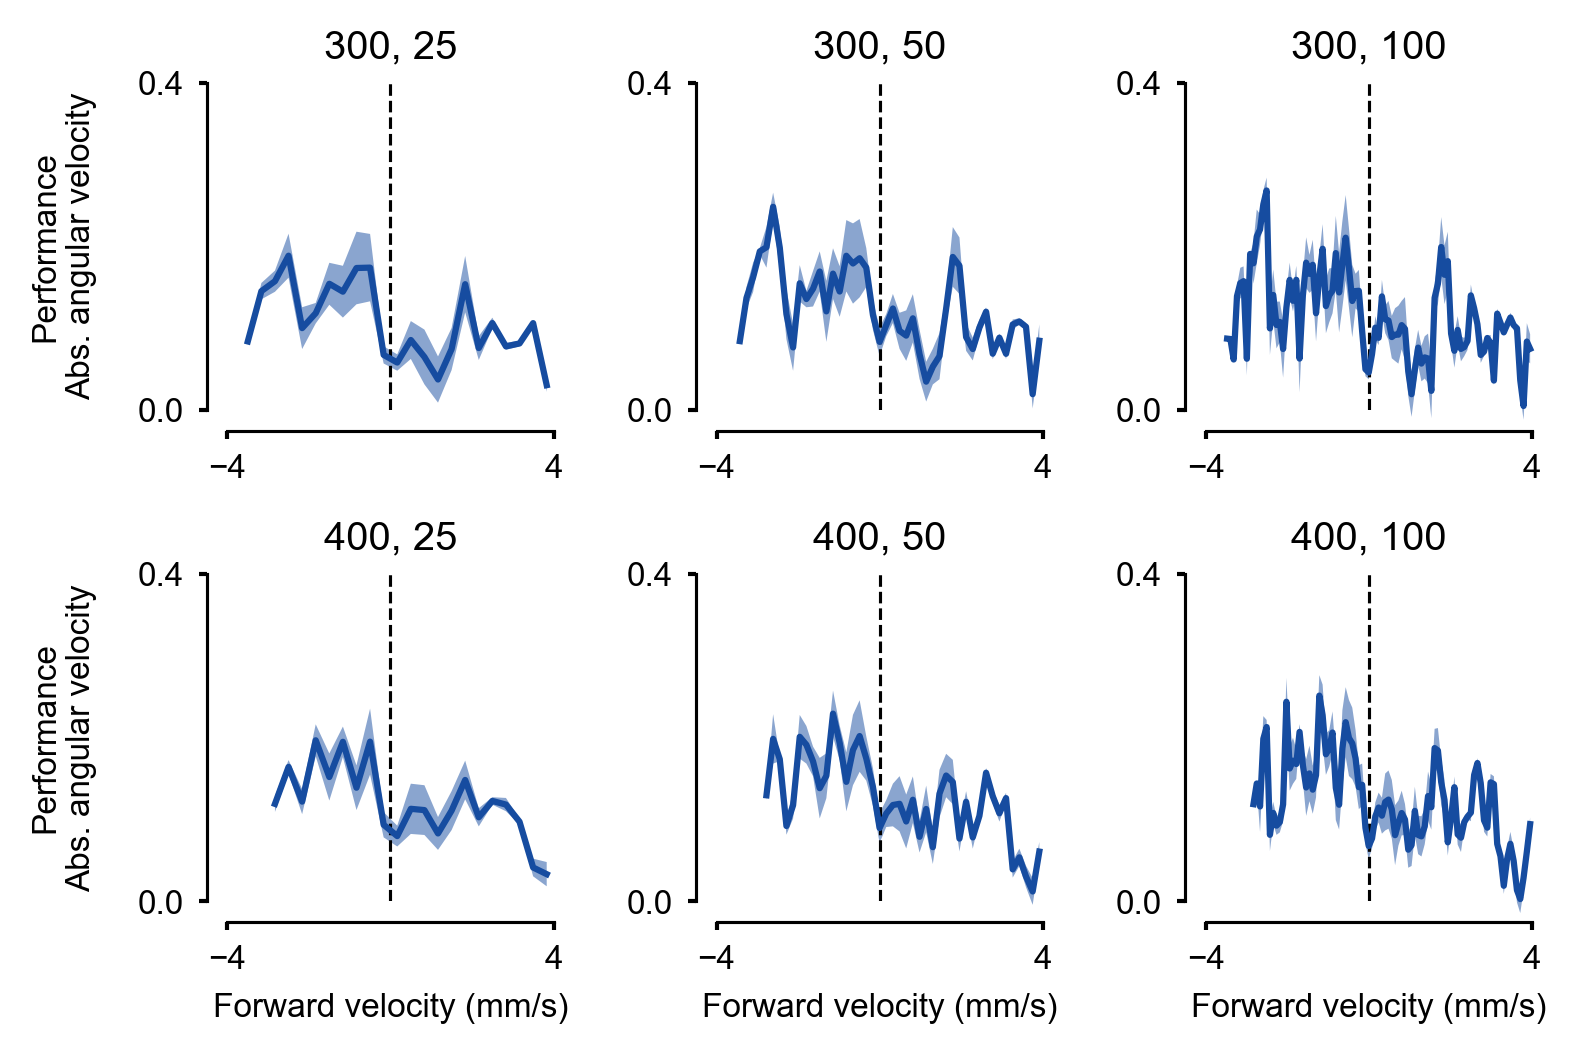

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\3710005074.py:35: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\3710005074.py:36: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\3710005074.py:35: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_

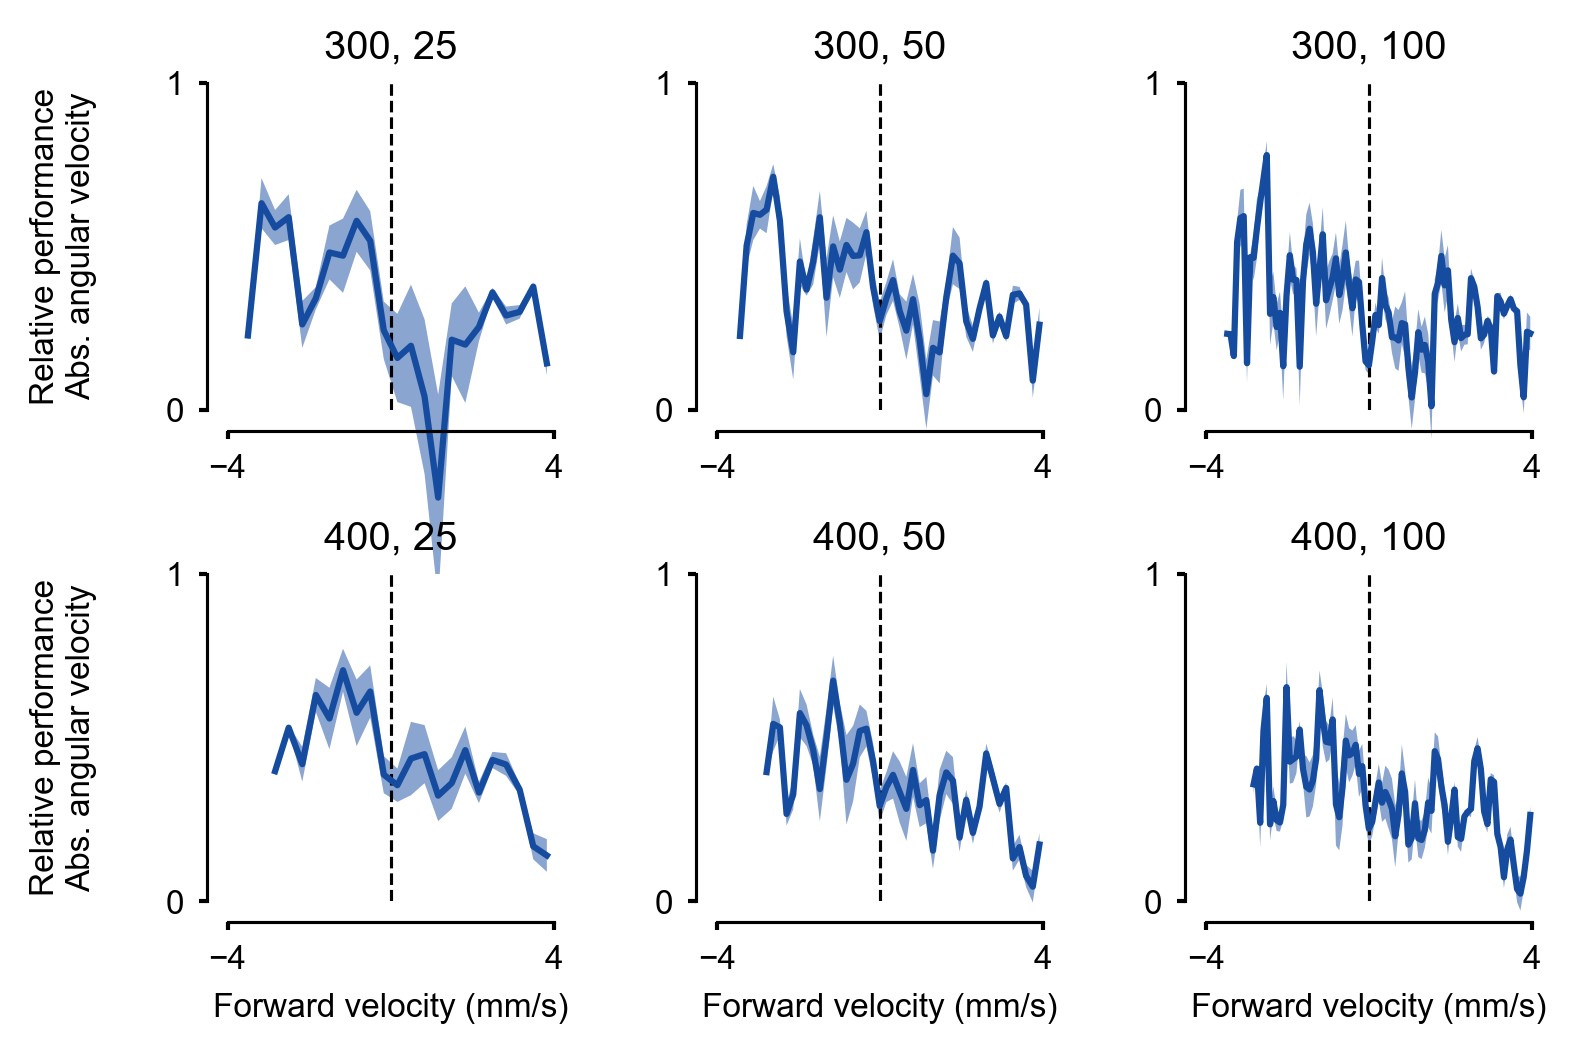

In [21]:
xlims = [-4,4]
# normalize_traces = False
# ylims = [0,0.4]
clip_on = False
DN = 'MDN'
color = color_perDN_dict[DN]

hspace = 0.5
wspace = 0.5
height_ratios = [1.25,1.25]
width_ratios = [1.25,1.25,1.25]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

for ylims, normalize_traces, extra_name, extra_ylabel in zip([(0,0.4),(0,1)],[False,True],['A','B'],['Performance','Relative performance']):
    fig, axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)

    for iroll, rolling_window in enumerate([300,400]):
        for ibin, nbins in enumerate([25,50,100]):
            ax=axes[iroll,ibin]
            
            ax.axvline(x=0,color='k',lw=0.75, linestyle='--')
            bins = np.linspace(xlims[0],xlims[1],nbins)

            plot_df = df[df.DN == DN].copy().reset_index(drop=True)
            plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
            plot_df = plot_df[~((plot_df.DN == 'DopaMeander')&(plot_df.side == 'undefined'))].reset_index(drop=True)
            selected_df = plot_df.reset_index(drop=True)

            try:
                final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_fwd',predicted='abs_v_ang', bins = bins, rolling_window = rolling_window, analysis_name='continuous_NL_all')

                if normalize_traces:
                    stack_traces = stack_traces / np.nanmax(stack_traces, axis=0, keepdims=True)

                ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
                ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
                ax.set_xlim(xlims)
                ax.set_xticks(xlims)
                ax.set_ylim(ylims)
                ax.set_yticks(ylims)
                ax.set_xlabel(f'Forward velocity (mm/s)')
                ax.set_ylabel(f'{extra_ylabel}\nAbs. angular velocity')
                ax.yaxis.set_label_coords(-0.4, 0.5)
                ax.spines['bottom'].set_position(('outward', 5))
                ax.spines['left'].set_position(('outward', 5))

                # final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_fwd',predicted='abs_v_ang', bins = bins, rolling_window = rolling_window, analysis_name='continuous_all')

                # if normalize_traces:
                #     stack_traces = stack_traces / np.nanmax(stack_traces, axis=0, keepdims=True)

                # ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color='r', clip_on=False)
                # ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor='r', alpha=0.5, clip_on=False)

                # custom_lines = [mpl.lines.Line2D([0], [0], color=color, lw=1) for color in [color_perDN_dict[DN], 'r']]
                # ax.legend(custom_lines, ['linear','nonlinear'], frameon=False, loc='upper left', bbox_to_anchor=(1., 1.))

                ax.set_title(f'{rolling_window}, {nbins}')
                # ax.set_xlim([-4,4])

            except ValueError:
                print('VALUE_ERROR, ', rolling_window, nbins)
                continue
    for ax in axes[:,1:].flatten():
        ax.set_ylabel('')
    for ax in axes[0,:].flatten():
        ax.set_xlabel('')
    plt.savefig(f'fig/MDN_predicts_backwards_turn_NLCOMPARISON_{extra_name}.png', transparent=False, bbox_inches='tight', dpi=300)
    plt.show()


2022_11_25_0009 may have constant prediction
2023_07_14_0000 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\3819302417.py:51: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\3819302417.py:52: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022_07_05_0010 may have constant prediction
2022_07_05_0011 may have constant prediction
2022_07_05_0013 may have constant prediction
2024_11_29_0001 may have constant prediction
2024_11_29_0001 may have constant prediction
2024_11_29_0001 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\3819302417.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'fig/rolling_windows_supplements_{nbins}.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


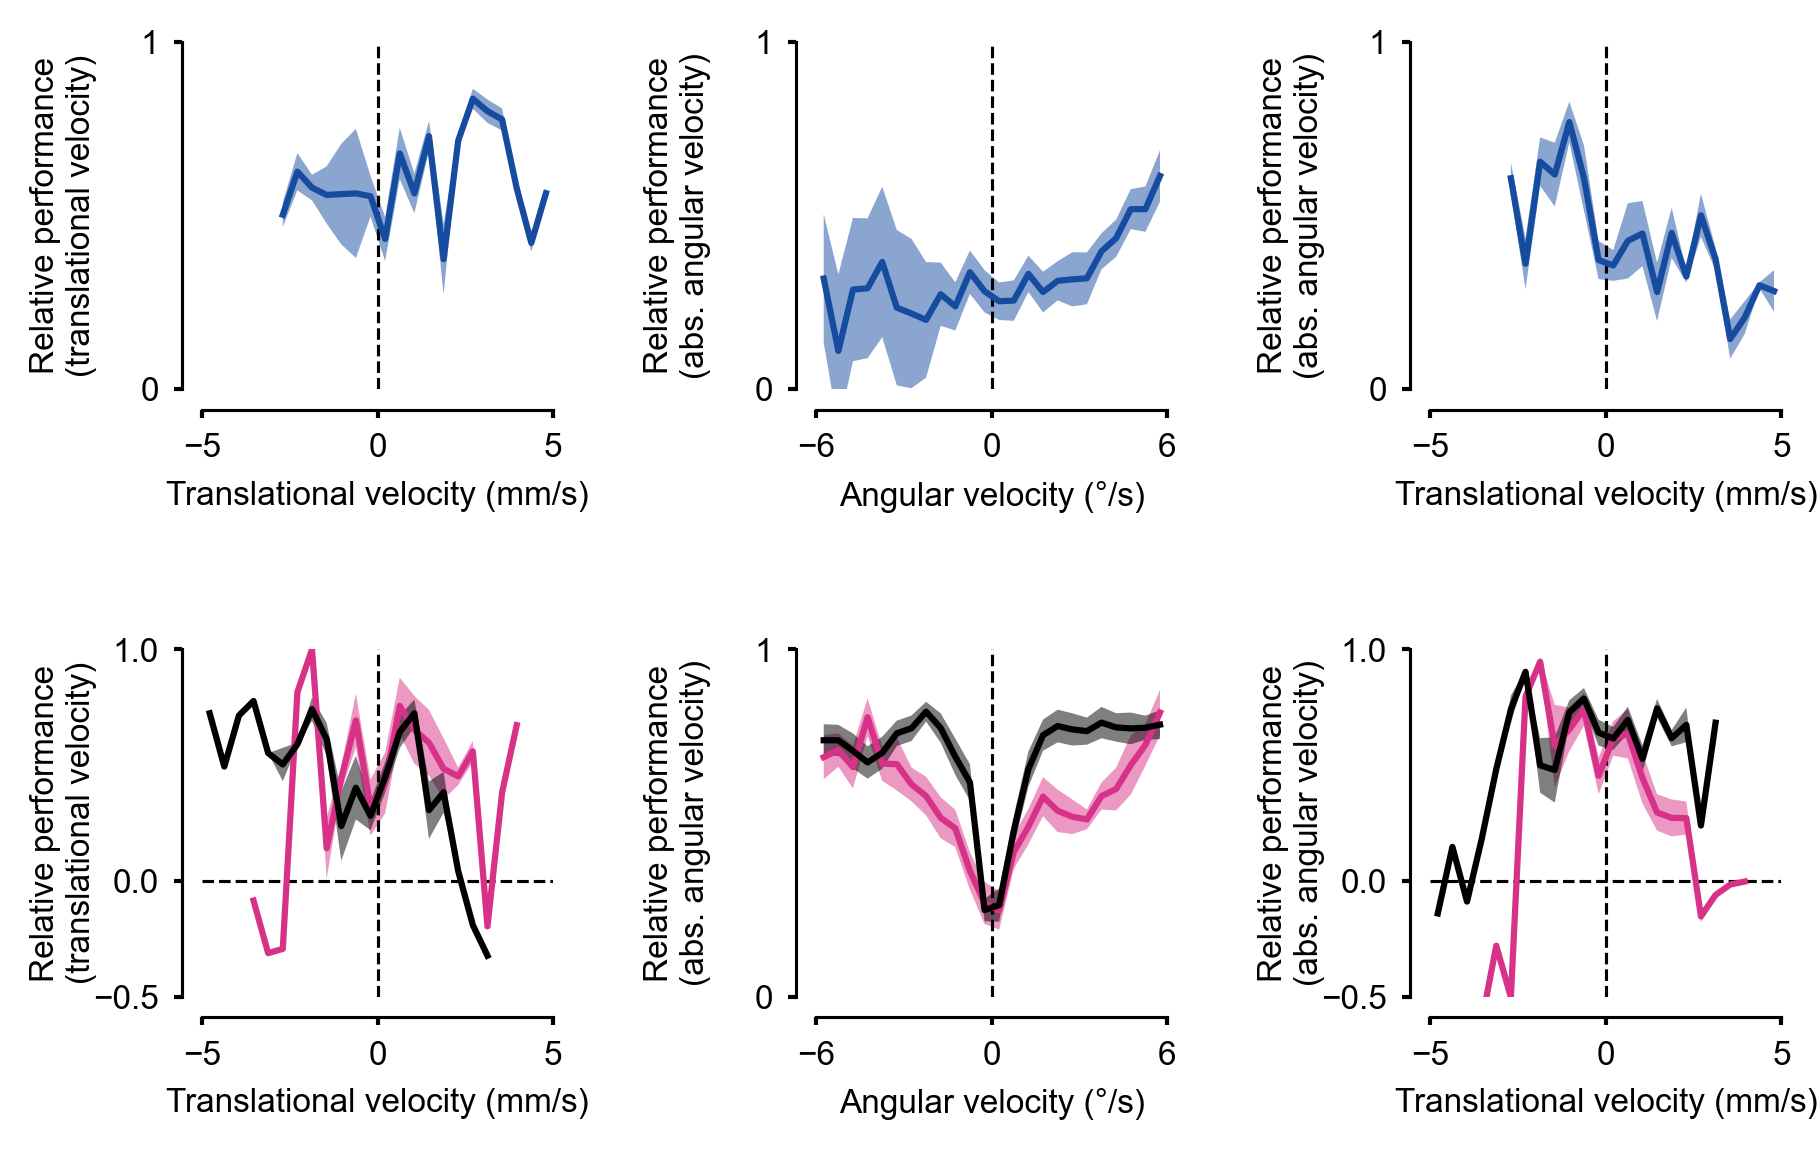

In [49]:
normalize_traces = True
ylims = [0,1]
clip_on = True
rolling_window = 400
nbins = 25

# datefolder = f'{results_dir_path}/2025_glms_noZ_fixedbins_linearextrapolation'
datadf_plot = df.copy() #pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
datadf_plot.loc[datadf_plot.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = datadf_plot[~((datadf_plot.DN == 'DopaMeander')&(datadf_plot.side == 'undefined'))].reset_index(drop=True)

hspace = 0.75
wspace = 0.75
nrows = 2
ncols = 3
height_ratios = [1+hspace/nrows]*nrows
width_ratios = [1+wspace/ncols]*ncols

panel_list = [
    ('MDN', 'v_fwd','v_fwd', 'Translational velocity (mm/s)', 'Relative performance\n(translational velocity)', (-5,5)),
    # ('MDN', 'v_fwd','abs_v_fwd', 'Translational velocity (mm/s)', 'Relative performance\n(abs. forward velocity)', (-5,5)),
    ('MDN', 'v_ang','abs_v_ang', 'Angular velocity (°/s)', 'Relative performance\n(abs. angular velocity)', (-6,6)),
    ('MDN', 'v_fwd','abs_v_ang', 'Translational velocity (mm/s)', 'Relative performance\n(abs. angular velocity)', (-5,5)),
    ('DopaMeander', 'v_fwd','v_fwd', 'Translational velocity (mm/s)', 'Relative performance\n(translational velocity)', (-5,5)),
    # ('DopaMeander', 'v_fwd','abs_v_fwd', 'Translational velocity (mm/s)', 'Relative performance\n(abs. translational velocity)', (-5,5)),
    ('DopaMeander', 'v_ang','abs_v_ang', 'Angular velocity (°/s)', 'Relative performance\n(abs. angular velocity)', (-6,6)),
    ('DopaMeander', 'v_fwd','abs_v_ang', 'Translational velocity (mm/s)', 'Relative performance\n(abs. angular velocity)', (-5,5)),
    ]

gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

fig, axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(0.5+sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
axes = axes.flatten()
for iax, (DN, ref_var, pred_var, xlabel, ylabel, xlims) in enumerate(panel_list):
    bins = np.linspace(xlims[0],xlims[1],nbins)
    ax = axes[iax]
    ax.axvline(x=0,color='k',lw=0.75, linestyle='--')
    if DN == 'MDN':
        sides = ['undefined']
    else:
        sides = ['left','right']
    
    for side in sides:
        color = color_perside_dict[DN+' '+side]
        selected_df = plot_df[(plot_df.DN == DN)&(plot_df.side==side)].reset_index(drop=True)

        try:
            final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference=ref_var,predicted=pred_var, bins = bins, rolling_window = rolling_window, analysis_name='continuous_NL_all')
            if normalize_traces:
                stack_traces = stack_traces / np.nanmax(stack_traces, axis=0, keepdims=True)
            ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color, clip_on=clip_on)
            ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5, clip_on=clip_on)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        except ValueError:
            print('VALUE_ERROR, ', rolling_window, nbins)
            continue


    ax.set_xlim(xlims)
    ax.set_xticks([xlims[0],0,xlims[1]])
    ax.set_ylim(ylims)
    ax.set_yticks(ylims)
    ax.yaxis.set_label_coords(-0.3, 0.5)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))

for iax in [3,5]:
    axes[iax].set_ylim([-0.5,1])
    axes[iax].set_yticks([-0.5,0,1])
    axes[iax].axhline(y=0,color='k',lw=0.75, linestyle='--',zorder=-1)

plt.savefig(f'fig/rolling_windows_supplements_{nbins}.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()


# Old rolling correlation plots

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1482139992.py:23: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1482139992.py:24: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


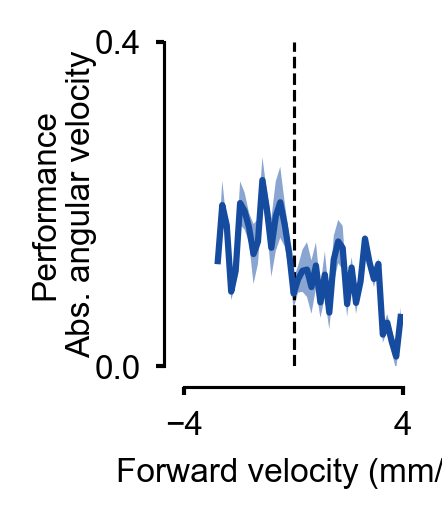

In [23]:
xlims = [-4,4]
ylims = [0,0.4]
bins = np.linspace(xlims[0],xlims[1],50)
DN = 'MDN'
color = color_perDN_dict[DN]

plot_df = df[df.DN == DN].copy().reset_index(drop=True)
plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = plot_df[~((plot_df.DN == 'DopaMeander')&(plot_df.side == 'undefined'))].reset_index(drop=True)

selected_df = plot_df.reset_index(drop=True)
final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_fwd',predicted='abs_v_ang', bins = bins, rolling_window = 400, analysis_name='continuous_NL_all')

hspace = 0
wspace = 0
height_ratios = [1.5]
width_ratios = [1.5]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
ax.axvline(x=0,color='k',lw=0.75, linestyle='--')

ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color)
ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5)
ax.set_xlim(xlims)
ax.set_xticks(xlims)
ax.set_ylim(ylims)
ax.set_yticks(ylims)
ax.set_xlabel(f'Forward velocity (mm/s)')
ax.set_ylabel(f'Performance\nAbs. angular velocity')
ax.yaxis.set_label_coords(-0.4, 0.5)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

# plt.savefig('fig/MDN_predicts_backwards_turn.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

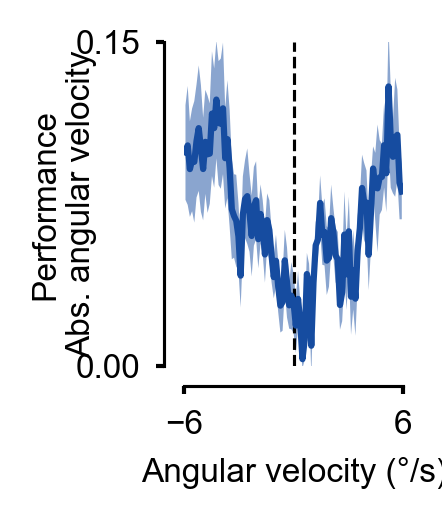

2022_08_18_0000 may have constant prediction
2022_11_25_0012 may have constant prediction
2022_11_25_0013 may have constant prediction
2023_01_26_0006 may have constant prediction
2023_01_26_0020 may have constant prediction
2023_02_21_0006 may have constant prediction
2023_08_11_0009 may have constant prediction
2023_08_15_0000 may have constant prediction


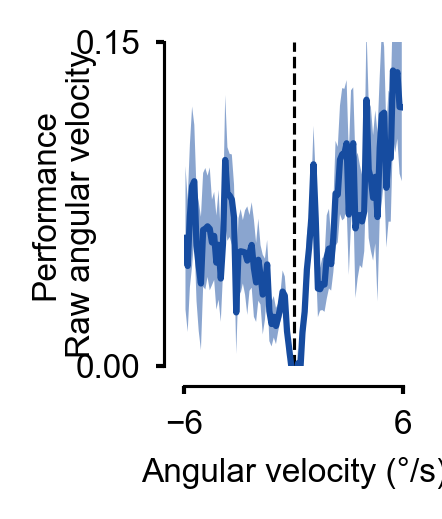

In [24]:
xlims = [-6,6]
ylims = [0,0.15]
bins = np.linspace(xlims[0],xlims[1],100)
DN = 'MDN'
color = color_perDN_dict[DN]

plot_df = df[df.DN == DN].copy().reset_index(drop=True)
plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = plot_df[~((plot_df.DN == 'DopaMeander')&(plot_df.side == 'undefined'))].reset_index(drop=True)

selected_df = plot_df.reset_index(drop=True)
final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_ang',predicted='abs_v_ang', bins = bins, rolling_window = 300, analysis_name='continuous_NL_all')

hspace = 0
wspace = 0
height_ratios = [1.5]
width_ratios = [1.5]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
ax.axvline(x=0,color='k',lw=0.75, linestyle='--')
# ax.axhline(y=0,color='k',lw=0.75, linestyle='--')

ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color,clip_on=True)
ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5,clip_on=True)
ax.set_xlim(xlims)
ax.set_xticks(xlims)
ax.set_ylim(ylims)
ax.set_yticks(ylims)
ax.set_xlabel(f'Angular velocity (°/s)')
ax.set_ylabel(f'Performance\nAbs. angular velocity')
ax.yaxis.set_label_coords(-0.4, 0.5)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

# plt.savefig('fig/MDN_turning_direction_attempt.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

xlims = [-6,6]
ylims = [0,0.15]
bins = np.linspace(xlims[0],xlims[1],100)
DN = 'MDN'
color = color_perDN_dict[DN]

plot_df = df[df.DN == DN].copy().reset_index(drop=True)
plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = plot_df[~((plot_df.DN == 'DopaMeander')&(plot_df.side == 'undefined'))].reset_index(drop=True)

selected_df = plot_df.reset_index(drop=True)
final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_ang',predicted='v_ang', bins = bins, rolling_window = 300, analysis_name='continuous_NL_all')

hspace = 0
wspace = 0
height_ratios = [1.5]
width_ratios = [1.5]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
ax.axvline(x=0,color='k',lw=0.75, linestyle='--')
# ax.axhline(y=0,color='k',lw=0.75, linestyle='--')

ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color,clip_on=True)
ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5,clip_on=True)
ax.set_xlim(xlims)
ax.set_xticks(xlims)
ax.set_ylim(ylims)
ax.set_yticks(ylims)
ax.set_xlabel(f'Angular velocity (°/s)')
ax.set_ylabel(f'Performance\nRaw angular velocity')
ax.yaxis.set_label_coords(-0.4, 0.5)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

# plt.savefig('fig/MDN_turning_direction_attempt_2.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

2022_11_25_0011 may have constant prediction
2023_02_21_0006 may have constant prediction
2023_08_15_0000 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1722830477.py:24: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color,clip_on=True)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1722830477.py:25: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5,clip_on=True)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


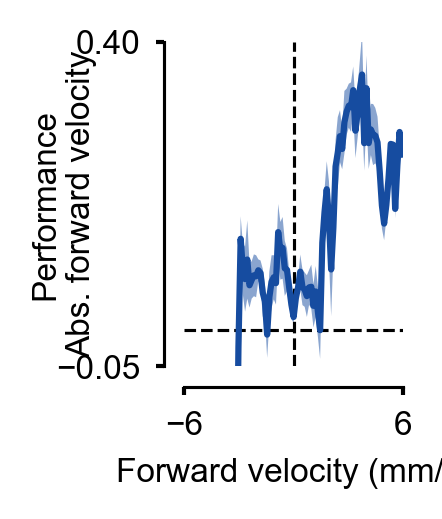

2022_11_25_0009 may have constant prediction
2023_07_14_0000 may have constant prediction


C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1722830477.py:61: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color,clip_on=True)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1722830477.py:62: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5,clip_on=True)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


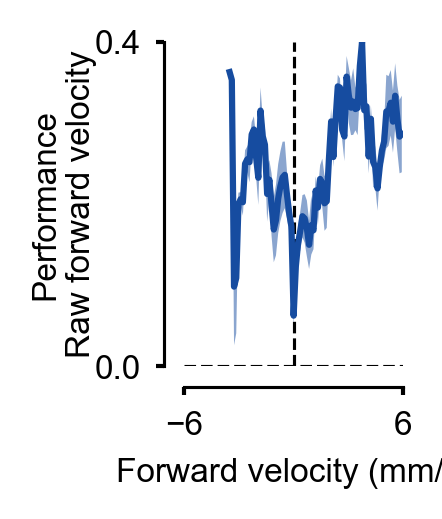

In [25]:
xlims = [-6,6]
ylims = [-0.05,0.4]
bins = np.linspace(xlims[0],xlims[1],100)
DN = 'MDN'
color = color_perDN_dict[DN]

plot_df = df[df.DN == DN].copy().reset_index(drop=True)
plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = plot_df[~((plot_df.DN == 'DopaMeander')&(plot_df.side == 'undefined'))].reset_index(drop=True)

selected_df = plot_df.reset_index(drop=True)
final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_fwd',predicted='abs_v_fwd', bins = bins, rolling_window = 300, analysis_name='continuous_NL_all')

hspace = 0
wspace = 0
height_ratios = [1.5]
width_ratios = [1.5]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
ax.axvline(x=0,color='k',lw=0.75, linestyle='--')
ax.axhline(y=0,color='k',lw=0.75, linestyle='--')

ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color,clip_on=True)
ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5,clip_on=True)
ax.set_xlim(xlims)
ax.set_xticks(xlims)
ax.set_ylim(ylims)
ax.set_yticks(ylims)
ax.set_xlabel(f'Forward velocity (mm/s)')
ax.set_ylabel(f'Performance\nAbs. forward velocity')
ax.yaxis.set_label_coords(-0.4, 0.5)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

plt.show()

xlims = [-6,6]
ylims = [0,0.4]
bins = np.linspace(xlims[0],xlims[1],100)
DN = 'MDN'
color = color_perDN_dict[DN]

plot_df = df[df.DN == DN].copy().reset_index(drop=True)
plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = plot_df[~((plot_df.DN == 'DopaMeander')&(plot_df.side == 'undefined'))].reset_index(drop=True)

selected_df = plot_df.reset_index(drop=True)
final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_fwd',predicted='v_fwd', bins = bins, rolling_window = 300, analysis_name='continuous_NL_all')

hspace = 0
wspace = 0
height_ratios = [1.5]
width_ratios = [1.5]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
ax.axvline(x=0,color='k',lw=0.75, linestyle='--')
ax.axhline(y=0,color='k',lw=0.75, linestyle='--')

ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color,clip_on=True)
ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5,clip_on=True)
ax.set_xlim(xlims)
ax.set_xticks(xlims)
ax.set_ylim(ylims)
ax.set_yticks(ylims)
ax.set_xlabel(f'Forward velocity (mm/s)')
ax.set_ylabel(f'Performance\nRaw forward velocity')
ax.yaxis.set_label_coords(-0.4, 0.5)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

plt.show()

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\2838908153.py:20: RuntimeWarning: Mean of empty slice
  ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\2838908153.py:21: RuntimeWarning: Mean of empty slice
  ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5)
c:\mambaforge\envs\glm_kans\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2024_11_29_0001 may have constant prediction


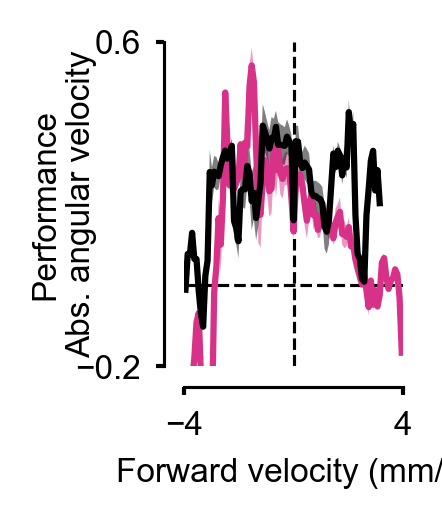

In [26]:
xlims = [-4,4]
ylims = [-0.2,0.6]
bins = np.linspace(xlims[0],xlims[1],100)
DN = 'DopaMeander'

plot_df = df.copy().reset_index(drop=True)
plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = plot_df[~((plot_df.DN == 'DopaMeander')&(plot_df.side == 'undefined'))].reset_index(drop=True)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
ax.axvline(x=0,color='k',lw=0.75, linestyle='--')
ax.axhline(y=0,color='k',lw=0.75, linestyle='--')

for side in ['left','right']:
    color = color_perside_dict[DN+' '+side]

    selected_df = plot_df[(plot_df.DN == DN)&(plot_df.side==side)].reset_index(drop=True)
    final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_fwd',predicted='abs_v_ang',rolling_window = 300, bins=bins, analysis_name='continuous_NL_all')

    ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color)
    ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5)

ax.set_xlim(xlims)
ax.set_xticks(xlims)
ax.set_ylim(ylims)
ax.set_yticks(ylims)
ax.set_xlabel(f'Forward velocity (mm/s)')
ax.set_ylabel(f'Performance\nAbs. angular velocity')
ax.yaxis.set_label_coords(-0.4, 0.5)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

# plt.savefig('fig/DM_predicts_fwd_and_bwd_turning.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

2024_11_29_0001 may have constant prediction


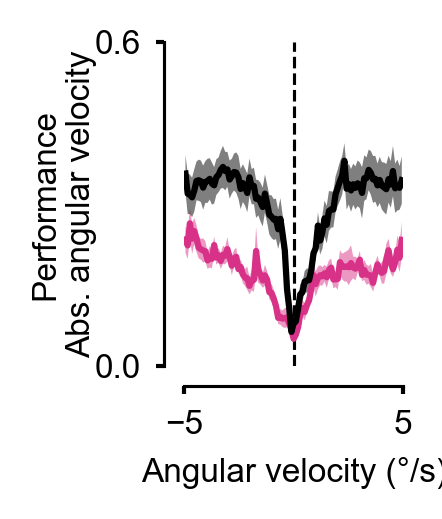

In [27]:
xlims = [-5,5]
ylims = [0,0.6]
bins = np.linspace(xlims[0],xlims[1],100)
DN = 'DopaMeander'

plot_df = df.copy().reset_index(drop=True)
plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = plot_df[~((plot_df.DN == 'DopaMeander')&(plot_df.side == 'undefined'))].reset_index(drop=True)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
ax.axvline(x=0,color='k',lw=0.75, linestyle='--')

for side in ['left','right']:
    color = color_perside_dict[DN+' '+side]

    selected_df = plot_df[(plot_df.DN == DN)&(plot_df.side==side)].reset_index(drop=True)
    final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_ang',predicted='abs_v_ang',rolling_window = 300, bins=bins, analysis_name='continuous_NL_all')

    ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color)
    ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5)

ax.set_xlim(xlims)
ax.set_xticks(xlims)
ax.set_ylim(ylims)
ax.set_yticks(ylims)
ax.set_xlabel(f'Angular velocity (°/s)')
ax.set_ylabel(f'Performance\nAbs. angular velocity')
ax.yaxis.set_label_coords(-0.4, 0.5)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

# plt.savefig('fig/DM_rolling_window_sideness.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

2024_11_29_0001 may have constant prediction


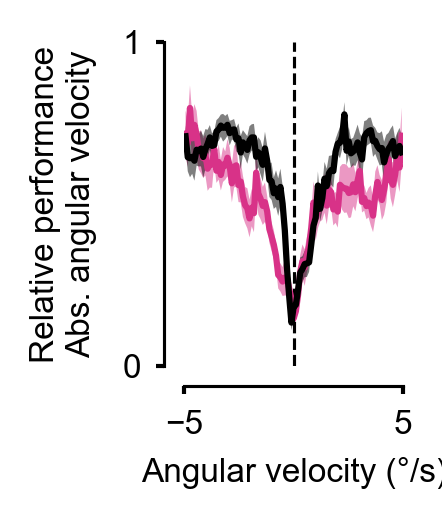

In [28]:
xlims = [-5,5]
ylims = [0,1]
bins = np.linspace(xlims[0],xlims[1],100)
DN = 'DopaMeander'
normalize_traces = True

plot_df = df.copy().reset_index(drop=True)
plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = plot_df[~((plot_df.DN == 'DopaMeander')&(plot_df.side == 'undefined'))].reset_index(drop=True)

hspace = 0
wspace = 0
height_ratios = [1.5]
width_ratios = [1.5]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
ax.axvline(x=0,color='k',lw=0.75, linestyle='--')

for side in ['left','right']:
    color = color_perside_dict[DN+' '+side]

    selected_df = plot_df[(plot_df.DN == DN)&(plot_df.side==side)].reset_index(drop=True)
    final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_ang',predicted='abs_v_ang',rolling_window = 300, bins=bins, analysis_name='continuous_NL_all')

    if normalize_traces:
        stack_traces = stack_traces / np.nanmax(stack_traces, axis=0, keepdims=True)

    ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color)
    ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5)

ax.set_xlim(xlims)
ax.set_xticks(xlims)
ax.set_ylim(ylims)
ax.set_yticks(ylims)
ax.set_xlabel(f'Angular velocity (°/s)')
ax.set_ylabel(f'Relative performance\nAbs. angular velocity')
ax.yaxis.set_label_coords(-0.4, 0.5)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

# plt.savefig('fig/DM_rolling_window_sideness_normalized.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

2024_11_29_0001 may have constant prediction


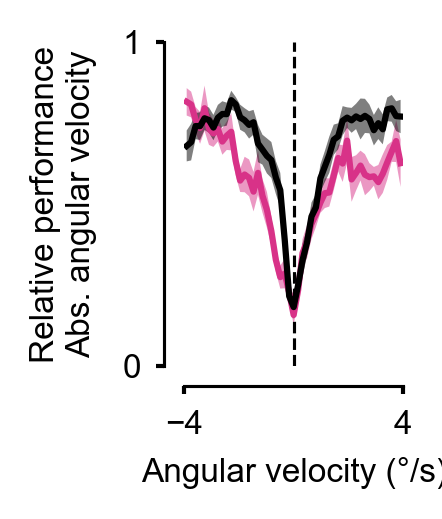

In [29]:
xlims = [-4,4]
ylims = [0,1]
bins = np.linspace(xlims[0],xlims[1],50)
DN = 'DopaMeander'
normalize_traces = True

plot_df = df.copy().reset_index(drop=True)
plot_df.loc[plot_df.DN == 'imposter','DN'] = 'DopaMeander'
plot_df = plot_df[~((plot_df.DN == 'DopaMeander')&(plot_df.side == 'undefined'))].reset_index(drop=True)

hspace = 0
wspace = 0
height_ratios = [1.5]
width_ratios = [1.5]
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
ax.axvline(x=0,color='k',lw=0.75, linestyle='--')

for side in ['left','right']:
    color = color_perside_dict[DN+' '+side]

    selected_df = plot_df[(plot_df.DN == DN)&(plot_df.side==side)].reset_index(drop=True)
    final_bin_centers, stack_traces = rolling_window_traces(plot_df=selected_df,reference='v_ang',predicted='abs_v_ang',rolling_window = 400, bins=bins, analysis_name='continuous_NL_all')

    if normalize_traces:
        stack_traces = stack_traces / np.nanmax(stack_traces, axis=0, keepdims=True)

    ax.plot(final_bin_centers, np.nanmean(stack_traces,axis=1), lw=1.5, color=color)
    ax.fill_between(final_bin_centers, np.nanmean(stack_traces,axis=1)-(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), np.nanmean(stack_traces,axis=1)+(np.nanstd(stack_traces,axis=1)/np.sqrt(stack_traces.shape[1])), edgecolor=None, facecolor=color, alpha=0.5)

ax.set_xlim(xlims)
ax.set_xticks(xlims)
ax.set_ylim(ylims)
ax.set_yticks(ylims)
ax.set_xlabel(f'Angular velocity (°/s)')
ax.set_ylabel(f'Relative performance\nAbs. angular velocity')
ax.yaxis.set_label_coords(-0.4, 0.5)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))

# plt.savefig('fig/DM_rolling_window_sideness_normalized.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# DNp17 comparison

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\250352151.py:29: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], ax=ax,alpha=1,dodge=True,legend=False, size=2, edgecolor='none')
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\250352151.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'fig/scores_DNp17_comparison.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


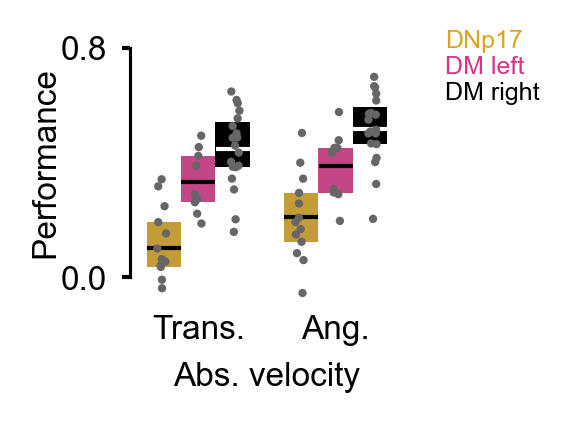

In [45]:
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'

df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot['DN_specific'] = df_plot['DN']
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
df_plot = df_plot[df_plot.DN != 'DopaMeander undefined'].reset_index(drop=True)

plot_variables_list = ['abs_v_fwd','abs_v_ang']
plot_variables_labels =  ['Trans.','Ang.']
DN_list_order = ['DNp17','DopaMeander left','DopaMeander right']
ylims=[0,0.8]

height_ratios = [1]
width_ratios = [1]
wspace = 0.2
hspace = 0.2
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)

sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 1},meanprops={"marker": "_", "markersize": 8, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5}, medianprops={"visible": False}, width=0.75)
mean_lines = [child for child in ax.get_children() if isinstance(child, Line2D) and child.get_marker() == '_']
for i, line in enumerate(mean_lines):
    if i>3:
        line.set_markerfacecolor('w')
        line.set_markeredgecolor('w')

sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], ax=ax,alpha=1,dodge=True,legend=False, size=2, edgecolor='none')

ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='center',fontsize=8)
ax.tick_params(axis='x', which='major', length=0)
ax.set_yticks(ylims)
ax.set_xlabel('Abs. velocity')
ax.set_ylabel('Performance',fontsize=8)
trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-0.25, (ylims[1]-ylims[0])/2,transform=trans)
ax.spines['bottom'].set_visible(False)
ax.set_ylim([ylims[0]-0.15,ylims[1]])
ax.spines[['left']].set_bounds(ylims)
ax.spines['bottom'].set_position(('outward', -5))

for iDN, DN, DNname in zip(range(3), DN_list_order, ['DNp17','DM left', 'DM right']):
    ax.text(1.8,0.8-iDN*0.09,DNname,color=color_perside_dict[DN],fontsize=6)

plt.savefig(f'fig/scores_DNp17_comparison.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# All performances

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1051985951.py:29: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], edgecolor='none', ax=ax,alpha=1,dodge=True,legend=False, size=2, linewidth=0.5)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1051985951.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'fig/scores_all_comparison.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


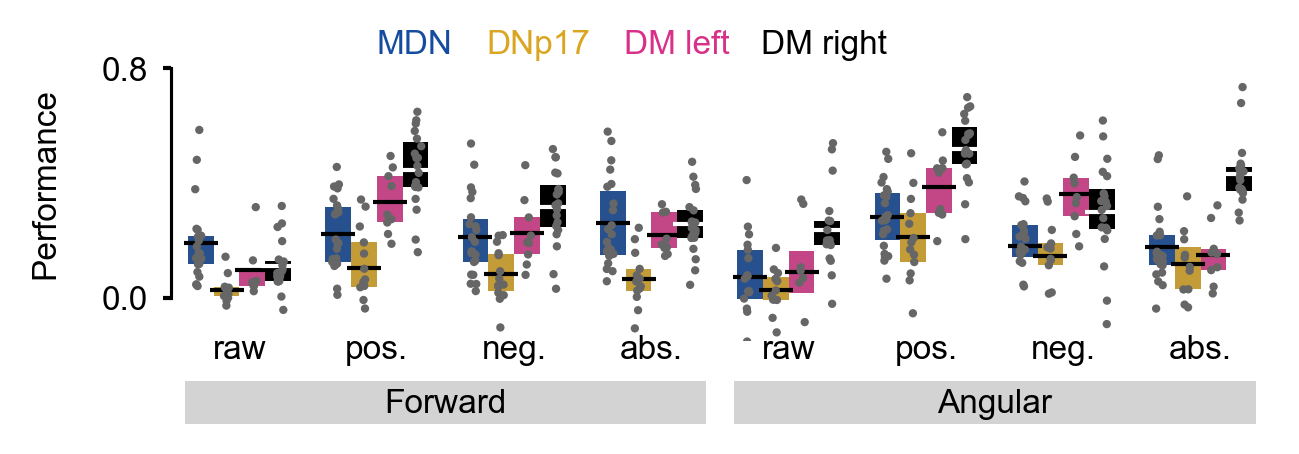

In [46]:
datefolder = f'{results_dir_path}/2025_glms_doublecheck_NL'

df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot['DN_specific'] = df_plot['DN']
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
df_plot = df_plot[df_plot.DN != 'DopaMeander undefined'].reset_index(drop=True)

plot_variables_list = ['v_fwd','abs_v_fwd','pos_v_fwd','neg_v_fwd','v_ang','abs_v_ang','pos_v_ang','neg_v_ang']
plot_variables_labels =  ['raw','pos.','neg.','abs.','raw','pos.','neg.','abs.']
DN_list_order = ['MDN','DNp17','DopaMeander left','DopaMeander right']
ylims=[0,0.8]

height_ratios = [1]
width_ratios = [4]
wspace = 0.2
hspace = 0.2
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)

fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)

sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 1},meanprops={"marker": "_", "markersize": 8, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5}, medianprops={"visible": False}, width=0.75)
mean_lines = [child for child in ax.get_children() if isinstance(child, Line2D) and child.get_marker() == '_']
for i, line in enumerate(mean_lines):
    if i>23:
        line.set_markerfacecolor('w')
        line.set_markeredgecolor('w')

sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], edgecolor='none', ax=ax,alpha=1,dodge=True,legend=False, size=2, linewidth=0.5)

ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='center',fontsize=8)
ax.tick_params(axis='x', which='major', length=0)
ax.set_yticks(ylims)

ax.add_patch(plt.Rectangle((-0.4,-0.44),3.8,0.15,facecolor='lightgrey',alpha=1,zorder=-1,clip_on=False))
ax.text(1.5,-0.4,'Forward',ha='center')
ax.add_patch(plt.Rectangle((3.6,-0.44),3.8,0.15,facecolor='lightgrey',alpha=1,zorder=-1,clip_on=False))
ax.text(5.5,-0.4,'Angular',ha='center')
ax.set_xlabel('')
ax.set_ylabel('Performance',fontsize=8)
trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-0.1, (ylims[1]-ylims[0])/2,transform=trans)
ax.spines['bottom'].set_visible(False)
ax.set_ylim([ylims[0]-0.15,ylims[1]])
ax.spines[['left']].set_bounds(ylims)
ax.spines['bottom'].set_position(('outward', -5))

for iDN, DN, DNname, xpos in zip(range(4), DN_list_order, ['MDN','DNp17','DM left', 'DM right'], [1,1.8,2.8,3.8]):
    ax.text(xpos,0.85,DNname,color=color_perside_dict[DN],fontsize=8)

plt.savefig(f'fig/scores_all_comparison.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# Cross-regressed performance

C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1100678981.py:35: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], ax=ax,alpha=0.5,dodge=True,legend=False, size=2, edgecolor='none')
C:\Users\apalaci\AppData\Local\Temp\ipykernel_6604\1100678981.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'fig/regressed_comparison.pdf', transparent=False, bbox_inches='tight', dpi=300)
c:\mambaforge\envs\glm_kans\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


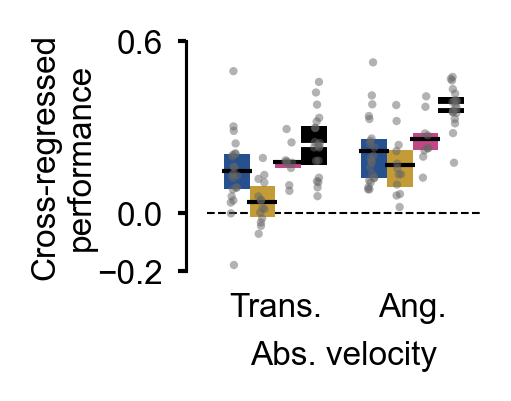

In [47]:
datefolder = f'{results_dir_path}/2025_glms_regressed_abs_v_fwd'
df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot['DN_specific'] = df_plot['DN']
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
df_plot = df_plot[df_plot.DN != 'DopaMeander undefined'].reset_index(drop=True)


plot_variables_list = ['abs_v_fwd','abs_v_ang']
plot_variables_labels = ['Trans.','Ang.']
DN_list_order = ['MDN','DNp17','DopaMeander left','DopaMeander right']

ylims=[-0.2,0.6]
height_ratios = [1]
width_ratios = [1]
wspace = 0.2
hspace = 0.2
gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)
fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)


ax.axhline(y=0,color='k',lw=0.5,linestyle='--')

# sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 7, "markeredgecolor": "k", "markerfacecolor": "k", "linewidth": 5}, medianprops={"visible": False, "color": "k"}) #\meanprops={"marker": "_", "markersize": 20, "color": "k", "linewidth": 5})
# sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict,ax=ax,alpha=0.3,dodge=True,legend=False)


sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 1},meanprops={"marker": "_", "markersize": 7, "markeredgecolor": 'k', "markerfacecolor": 'k', "linewidth": 5}, medianprops={"visible": False}, width=0.75)
mean_lines = [child for child in ax.get_children() if isinstance(child, Line2D) and child.get_marker() == '_']
for i, line in enumerate(mean_lines):
    if i>5:
        line.set_markerfacecolor('w')
        line.set_markeredgecolor('w')

sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=['#666666'], ax=ax,alpha=0.5,dodge=True,legend=False, size=2, edgecolor='none')



ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='top')
ax.set_xlabel('Abs. velocity')
ax.set_ylabel('Cross-regressed\nperformance')

ax.set_ylim([ylims[0]-0.15,ylims[1]])
ax.set_yticks([ylims[0],0,ylims[1]])
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', -5))

ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='center',fontsize=8)
ax.tick_params(axis='x', which='major', length=0)

ax.spines['bottom'].set_visible(False)
ax.spines[['left']].set_bounds(ylims)

trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
ax.yaxis.set_label_coords(-0.4, (ylims[1]+ylims[0])/2,transform=trans)

plt.savefig(f'fig/regressed_comparison.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

# Old code

In [33]:
# def _plot_filters(ax,lw=2,zero_line_lw=0.25):
#     for DN_side in filtered_df[(filtered_df.DN == DN_type)].side.unique():
#         if (DN_type == 'DopaMeander') and DN_side == 'left':
#             main_color = color_perside_dict['DopaMeander left']
#         elif (DN_type == 'DopaMeander') and DN_side == 'right':
#             main_color = color_perside_dict['DopaMeander right']
#         else:
#             main_color =color_perDN_dict[DN_type]
#
#         for iv, varname in enumerate(variables_list):
#             filename_list = filtered_df[(filtered_df.DN == DN_type)&(filtered_df.side == DN_side)].filename.tolist()
#             plot_glm_filter(ax=ax,estimated_filters_dict=estimated_filters_dict,filename_list=filename_list,varname=varname,T=T,main_color=main_color,with_l2=False,with_individual_traces=False,linestyle=variables_linestyle[iv],lw=lw,zero_line_lw=zero_line_lw)
#
#     ylims = ylims_dict[DN_type]
#     ax.set_ylim(ylims)
#     ax.set_yticks([ylims[0],0,ylims[1]])
#     ax.set_yticklabels([ylims[0],0,ylims[1]])
#
#     ax.set_ylabel('Amplitude')
#     ax.yaxis.set_label_coords(-0.3, 0.5)
#
#     ax.set_xlim([-3,0]) # 0.025])
#     ax.set_xticks([0,-3])
#     ax.set_xlabel('Time (s)',labelpad=0)

# datefolder = f'{results_dir_path}/2025_glms_noZ_fixedbins_linearextrapolation'
#
# filtered_df = df[~((df.DN == 'imposter') & (df.side == 'undefined'))].copy()
# filtered_df['DN_specific'] = filtered_df['DN']
# filtered_df.loc[filtered_df.DN == 'imposter','DN'] = 'DopaMeander'
# variables_list = ['v_fwd','abs_v_fwd']
# variables_labels = [r'$v_{fwd}$',r'$|v_{fwd}|$']
# variables_linestyle = ['solid',(0,(4,2))]
#
# label_dict = {'v_fwd':r'$v_{fwd}$','abs_v_fwd':r'$|v_{fwd}|$','pos_v_fwd':r'$v_{fwd}^+$','neg_v_fwd':r'$v_{fwd}^-$','v_ang':r'$v_{ang}$','abs_v_ang':r'$|v_{ang}|$','pos_v_ang':r'$v_{ang}^+$','neg_v_ang':r'$v_{ang}^-$'}
# ylims_dict_dict = {'v_fwd':{'DopaMeander': (-0.25,0.25), 'MDN': (-0.15,0.15)}, 'v_ang':{'DopaMeander': (-12,12), 'MDN': (-1.5,1.5)}}
#
# with open(f'{datefolder}/GLM_filters.pkl', 'rb') as handle:
#     estimated_filters_dict = pickle.load(handle)
#
# DN_list = ['MDN','DopaMeander']
#
# hspace = 1
# wspace = 1
# height_ratios = [1+hspace/2, 1+hspace/2]
# width_ratios = [1+wspace/2, 1+wspace/2]
# gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)
#
# for veltype in ['v_fwd','v_ang']:
#     ylims_dict = ylims_dict_dict[veltype]
#     fig,axes = plt.subplots(2,2,figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
#
#     for jv, variables_list in enumerate([[veltype,f'abs_{veltype}'],[f'pos_{veltype}',f'neg_{veltype}']]):
#         for iDN, DN_type in enumerate(DN_list):
#             ax = axes[jv,iDN]
#             _plot_filters(ax,lw=1)
#             if iDN == 1:
#                 ax.set_ylabel('')
#             custom_lines = [mpl.lines.Line2D([0], [0], color='k', lw=1, linestyle=linestyle) for linestyle in variables_linestyle]
#             ax.legend(custom_lines, [label_dict[varname] for varname in variables_list], frameon=False, loc='upper left', bbox_to_anchor=(0.7, 1.6)) # loc='upper right'
#     plt.savefig(f'fig/{veltype}_filters.pdf', transparent=False, bbox_inches='tight', dpi=300)
#     plt.show()

In [34]:
# def _plot_bars_DM(ax):
#     ax.axhline(y=0,color='k',lw=0.5)
#
#     marker_color = 'k'
#
#     sns.boxplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=['left','right'], palette=[color_perside_dict[DN+' '+side] for side in ['left','right']], ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 9, "markeredgecolor": marker_color, "markerfacecolor": marker_color, "linewidth": 5}, medianprops={"visible": False})
#
#     mean_lines = [child for child in ax.get_children() if isinstance(child, Line2D) and child.get_marker() == '_']
#     mean_facecolors = {'left': 'k', 'right': 'w'}
#     mean_edgecolors = {'left': 'k', 'right': 'w'}
#
#     for i, line in enumerate(mean_lines):
#         if i < 4:
#             hue = 'left'
#         else:
#             hue = 'right'
#         line.set_markerfacecolor(mean_facecolors[hue])
#         line.set_markeredgecolor(mean_edgecolors[hue])
#         # line.set_markersize(12)
#
#     sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='DN_side', order=variables_list, hue_order=['left','right'], palette=[color_perside_dict[DN+' '+side] for side in ['left','right']], ax=ax,alpha=0.3,dodge=True,legend=False)
#
#
#     ax.set_xticks(ax.get_xticks(), [label_dict[varname] for varname in variables_list], rotation=0, ha='center',va='center',fontsize=8)
#     ax.tick_params(axis='x', which='major', pad=10)
#     ax.set_ylim([0,0.8])
#     ax.set_yticks([0,0.8])
#     ax.set_xlabel('')
#
#     ax.set_ylabel('Performance',fontsize=8)
#     ax.yaxis.set_label_coords(-0.25, 0.5)
#
# def _plot_bars(ax):
#     ax.axhline(y=0,color='k',lw=0.5)
#
#     marker_color = 'w' if DN == 'DopaMeander right' else 'k'
#
#     sns.boxplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=[color_perside_dict[DN]], ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 18, "markeredgecolor": marker_color, "markerfacecolor": marker_color, "linewidth": 5}, medianprops={"visible": False})
#     sns.stripplot(data=df_plot[df_plot.DN == DN], x='varname',y='pearsonr_score',hue='varname', order=variables_list, palette=[color_perside_dict[DN]], ax=ax,alpha=0.3,dodge=False,legend=False)
#
#     ax.set_xticks(ax.get_xticks(), [label_dict[varname] for varname in variables_list], rotation=0, ha='center',va='center',fontsize=8)
#     ax.tick_params(axis='x', which='major', pad=10)
#     ax.set_ylim([0,0.6])
#     ax.set_yticks([0,0.6])
#     ax.set_xlabel('')
#
#     ax.set_ylabel('Performance',fontsize=8)
#     ax.yaxis.set_label_coords(-0.25, 0.5)
#
# datefolder = f'{results_dir_path}/2025_glms_noZ_fixedbins_linearextrapolation'
#
# df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
# df_plot['DN_specific'] = df_plot['DN']
# df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
# df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
# df_plot = df_plot[df_plot.DN != 'DopaMeander undefined'].reset_index(drop=True)
#
# DN_list_order = ['MDN']
#
# hspace = 0
# wspace = 1
# height_ratios = [1]
# width_ratios = [1.2+wspace/2, 1.2+wspace/2]
#
# gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)
#
# fig,axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
# for iv, veltype in enumerate(['v_fwd','v_ang']):
#
#     variables_list = [veltype, f'pos_{veltype}', f'neg_{veltype}', f'abs_{veltype}']
#
#     for DN in DN_list_order:
#         ax = axes[iv]
#         _plot_bars(ax)
#
#         # ax.yaxis.set_label_coords(-0.25, 0.5)
#
# fig.legend(frameon=False, loc='upper right',bbox_to_anchor=(1.1, 1.))
# plt.savefig(f'fig/bar_scores.pdf', transparent=False, bbox_inches='tight', dpi=300)
# plt.show()

# datefolder = f'{results_dir_path}/2025_glms_noZ_fixedbins_linearextrapolation'
#
# df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
# df_plot['DN_specific'] = df_plot['DN']
# df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
# df_plot = df_plot[~((df_plot.DN == 'DopaMeander')&(df_plot.DN_side == 'undefined'))].reset_index(drop=True)
# # df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
# # df_plot = df_plot[df_plot.DN != 'DopaMeander undefined'].reset_index(drop=True)
#
# DN_list_order = ['DopaMeander']
# hspace = 0
# wspace = 1
# height_ratios = [0.8]
# width_ratios = [1.2+wspace/2, 1.2+wspace/2]
# gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)
# fig,axes = plt.subplots(len(height_ratios),len(width_ratios),figsize=[(sum(width_ratios))*figsize_unit,(sum(height_ratios))*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
#
# for iv, veltype in enumerate(['v_fwd','v_ang']):
#     variables_list = [veltype, f'pos_{veltype}', f'neg_{veltype}', f'abs_{veltype}']
#
#     for DN in DN_list_order:
#         ax = axes[iv]
#         _plot_bars_DM(ax)
#
# fig.legend(frameon=False, loc='upper right',bbox_to_anchor=(1.1, 1.))
# plt.savefig(f'fig/DM_bar_scores.pdf', transparent=False, bbox_inches='tight', dpi=300)
# plt.show()

In [35]:
# datefolder = f'{results_dir_path}/2025_glms_noZ_fixedbins_linearextrapolation'
#
# df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
# df_plot['DN_specific'] = df_plot['DN']
# df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
# df_plot.loc[df_plot.DN == 'DopaMeander','DN'] = df_plot.loc[df_plot.DN == 'DopaMeander','DN'] + ' ' + df_plot.loc[df_plot.DN == 'DopaMeander','DN_side']
# df_plot = df_plot[df_plot.DN != 'DopaMeander undefined'].reset_index(drop=True)
#
# plot_variables_list = ['abs_v_fwd','abs_v_ang']
# plot_variables_labels =  ['abs.\nv. fwd.','abs.\nv. ang.']
# DN_list_order = ['DNp17','DopaMeander left','DopaMeander right']
#
# height_ratios = [1]
# width_ratios = [1]
# wspace = 0.2
# hspace = 0.2
# gs_kw = dict(width_ratios=width_ratios, height_ratios=height_ratios, wspace=wspace, hspace=hspace)
#
# fig, ax = plt.subplots(1,1,figsize=[(sum(width_ratios)+(len(width_ratios)-1)*wspace)*figsize_unit,(sum(height_ratios)+(len(height_ratios)-1)*hspace)*figsize_unit],dpi=300,layout='tight',gridspec_kw=gs_kw)
#
# marker_color = 'k'
# sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict, ax=ax, legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 20, "markeredgecolor": marker_color, "markerfacecolor": marker_color, "linewidth": 5}, medianprops={"visible": False})
# sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perside_dict, ax=ax,alpha=0.3,dodge=True,legend=False)
#
# ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='baseline')
# ax.tick_params(axis='x', which='major', pad=20)
# ax.set_ylim([0,0.75])
# ax.set_yticks([0,0.25,0.50,0.75])
# ax.set_xlabel('')
# # ax.grid(True)
# ax.set_ylabel('LN model score (R)')
# ax.yaxis.set_label_coords(-0.45, 0.5)
#
# for iDN, DN in enumerate(DN_list_order):
#     ax.text(1.5,1.1-iDN*0.12,DN,color=color_perside_dict[DN])
#
# plt.savefig(f'fig/scores_DNp17_comparison.pdf', transparent=False, bbox_inches='tight', dpi=300)
# plt.show()